In [1]:
# Parameters
notebook_fname = "NN_full_RepeatedKFold_v3_BO_3"


In [2]:
# Parameters
# notebook_fname = "NN_full_RepeatedKFold_v3_BO_1"


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Concatenate, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import scipy as sp
import seaborn as sns

import numpy as np
from numpy import asarray

import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
from tabulate import tabulate

import time
import GPyOpt
from multiprocessing import Pool

from joblib import Parallel, delayed
import concurrent.futures

import pickle

import warnings
warnings.filterwarnings("ignore")

import os
print(f'cpu_count: {os.cpu_count()}')

data_path  = './Dataset_Cleaned/'
model_path = './Model_Saved/'


# ----- BO-related -----
num_str        = notebook_fname.split("_")[-1]

try:
    bo_ens_num = int(num_str)
    print(f"bo_ens_num: {bo_ens_num}")
except ValueError:
    # if the string can't be converted to an integer, keep it as a string
    bo_ens_num = int(123)
    print(f"book master - bo_ens_num: {bo_ens_num}")
 

model_path_bo = f'./{model_path}/{notebook_fname}/'

if not os.path.exists(model_path_bo):
    os.makedirs(model_path_bo)
    print(f"Folder '{model_path_bo}' created.")
else:
    print(f"Folder '{model_path_bo}' already exists.")
# ----- BO-related -----

Flag_Training_try     = False
Flag_BO_search        = True
Flag_Training_BO_best = True


tf.keras.backend.clear_session()

2023-04-01 11:24:44.277925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-04-01 11:24:46.626251: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 11:24:46.626874: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 11:24:46.626898: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


cpu_count: 40
bo_ens_num: 3
Folder '././Model_Saved//NN_full_RepeatedKFold_v3_BO_3/' already exists.


### Use GPU or not

In [4]:
# # check the availablity of all GPU machiens
# gpus = tf.config.list_physical_devices('GPU')
# print(gpus)


# # select first GPU machine 
# tf.config.set_visible_devices(gpus[1], 'GPU')
# logical_gpus = tf.config.list_logical_devices('GPU')

# # verify the setup
# logical_gpus = tf.config.list_logical_devices('GPU')
# print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

# not using GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

### Import hardness training dataset

In [5]:
# define an empty df with column head defined
df_compo = pd.DataFrame(columns=['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn',
       'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf'])
 
# import Hardness dataset
df_H = pd.read_excel(data_path + 'Hardness_database_YW_v3.xlsx', header=2)

print(df_H.columns)

# obtain the 2 inputs and 1 output from this dataset
df_H_compo  = pd.concat([df_compo, df_H[['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn',
       'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf']]], axis=0, ignore_index=True)
df_H_compo = df_H_compo.fillna(0) # fill in the nan by zero
 
df_H_specific = df_H[['delta_a', 'Hmix', 'VEC', 'sigma_bulk_modulus']]
df_H_output = df_H['converted HV']
 
# df_H_compo.to_excel('checkcheck.xlsx')
print(df_H_compo.shape, df_H_specific.shape, df_H_output.shape)

# df_H_compo['Al'] = 0
# display(np.mean(df_H_compo['Al'].values))


Index(['Alloy ID', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn',
       'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf', 'delta_a',
       'Hmix', 'VEC', 'sigma_bulk_modulus', 'converted HV'],
      dtype='object')
(680, 20) (680, 4) (680,)


### Import corrosion training dataset

In [6]:
# import corrosion dataset
df_C = pd.read_excel(data_path + 'Corrosion_database_YW_v3.xlsx', header=2)

print(df_C.columns)

# obtain the 2 inputs and 1 output from this dataset
df_C_compo  = pd.concat([df_compo, df_C[['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn',
       'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y']]], axis=0, ignore_index=True)
df_C_compo = df_C_compo.fillna(0) # fill in the nan by zero

df_C_specific = df_C[['TestTemperature_C', 'ChlorideIonConcentration', 'pH', 'ScanRate_mVs']]
df_C_output = df_C['AvgPittingPotential_mV']

# df_C_compo.to_excel('checkcheck.xlsx')

print(df_C_compo.shape, df_C_specific.shape, df_C_output.shape)

# df_C_compo['Al'] = 0

Index(['Alloy ID', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn',
       'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'TestTemperature_C',
       'ChlorideIonConcentration', 'pH', 'ScanRate_mVs',
       'AvgPittingPotential_mV'],
      dtype='object')
(712, 20) (712, 4) (712,)


### Data preprocessing of datasets

#### hardness network: 
* input (X1): df_H_compo
* input (Y1): df_H_specific
* output(H1): df_H_output

#### corrosion network 
* input (X2): df_C_compo
* input (Z2): df_C_specific
* output(C2): df_C_output

#### obtain the MinMaxScaler from normalisation
 

In [7]:
# prepare inputs and outputs for NN
dfs = [df_H_compo, df_H_specific, df_H_output, 
       df_C_compo, df_C_specific, df_C_output]
inputs_outputs = [np.asarray(df.values) for df in dfs]

# assign variables
X1, Y1, H1, X2, Z2, C2 = inputs_outputs

# create the scalar
scaler_compo      = MinMaxScaler() # for input compo
scaler_H_specific = MinMaxScaler() # for input H specific
scaler_C_specific = MinMaxScaler() # for input H specific
scaler_H_output   = MinMaxScaler() # for H outputs
scaler_C_output   = MinMaxScaler() # for H outputs

scaler_compo.fit(np.concatenate((X1, X2)))
scaler_H_specific.fit(Y1)
scaler_C_specific.fit(Z2)
scaler_H_output.fit(H1.reshape((-1,1)))
scaler_C_output.fit(C2.reshape((-1,1)))

# Save the scalers to a file using pickle
with open(data_path + 'scalers.pkl', 'wb') as f:
    pickle.dump([scaler_compo, 
                 scaler_H_specific,
                 scaler_C_specific,
                 scaler_H_output, 
                 scaler_C_output], f)


#### RepeatedKFold

* for hardness: 
`X1_train_KFold`, `X1_test_KFold`, `Y1_train_KFold`, `Y1_test_KFold` , `H1_train_KFold`, `H1_test_KFold` as lists used in model training 

* for corrosion: 
`X2_train_KFold`, `X2_test_KFold`, `Z2_train_KFold`, `Z2_test_KFold` , `C2_train_KFold`, `C2_test_KFold` as lists used in model training 


In [8]:
# function for KFold split and normalisation
def kfold_with_norm(X, Y, H, 
                    scaler_X, scaler_Y, scaler_H, 
                    n_splits, n_repeats, random_state):
    
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

    X_train_KFold, X_test_KFold = [], []
    Y_train_KFold, Y_test_KFold = [], []
    H_train_KFold, H_test_KFold = [], []
    
    X_train_norm_KFold, X_test_norm_KFold = [], []
    Y_train_norm_KFold, Y_test_norm_KFold = [], []
    H_train_norm_KFold, H_test_norm_KFold = [], []

    for i, (train_ix, test_ix) in enumerate(cv.split(X)):

        # train-test split
        X_train, X_test = X[train_ix], X[test_ix]
        Y_train, Y_test = Y[train_ix], Y[test_ix]
        H_train, H_test = H[train_ix], H[test_ix]

        X_train_KFold.append(X_train)
        X_test_KFold.append(X_test)  
        Y_train_KFold.append(Y_train)  
        Y_test_KFold.append(Y_test)  
        H_train_KFold.append(H_train)  
        H_test_KFold.append(H_test)  

        # MinMaxScaler normalisation
        X_train_norm, X_test_norm = scaler_X.transform(X_train), scaler_X.transform(X_test )
        Y_train_norm, Y_test_norm = scaler_Y.transform(Y_train), scaler_Y.transform(Y_test )
        H_train_norm, H_test_norm = scaler_H.transform(H_train.reshape((-1,1))), scaler_H.transform(H_test.reshape((-1,1)))

        X_train_norm_KFold.append(X_train_norm)  
        X_test_norm_KFold.append(X_test_norm)  
        Y_train_norm_KFold.append(Y_train_norm)  
        Y_test_norm_KFold.append(Y_test_norm)  
        H_train_norm_KFold.append(H_train_norm)  
        H_test_norm_KFold.append(H_test_norm) 

    return (X_train_KFold, X_test_KFold, Y_train_KFold, Y_test_KFold, H_train_KFold, H_test_KFold, 
            X_train_norm_KFold, X_test_norm_KFold, Y_train_norm_KFold, Y_test_norm_KFold, H_train_norm_KFold, H_test_norm_KFold)


In [9]:
n_splits     = 6
n_repeats    = 2
random_state = 42 

# for hardness network
(X1_train_KFold, X1_test_KFold, 
 Y1_train_KFold, Y1_test_KFold, 
 H1_train_KFold, H1_test_KFold, 
 X1_train_norm_KFold, X1_test_norm_KFold, 
 Y1_train_norm_KFold, Y1_test_norm_KFold, 
 H1_train_norm_KFold, H1_test_norm_KFold) = kfold_with_norm(X1, Y1, H1, scaler_compo, scaler_H_specific, scaler_H_output, n_splits, n_repeats, random_state)

# for corrosion network
(X2_train_KFold, X2_test_KFold, 
 Z2_train_KFold, Z2_test_KFold, 
 C2_train_KFold, C2_test_KFold, 
 X2_train_norm_KFold, X2_test_norm_KFold, 
 Z2_train_norm_KFold, Z2_test_norm_KFold, 
 C2_train_norm_KFold, C2_test_norm_KFold) = kfold_with_norm(X2, Z2, C2, scaler_compo, scaler_C_specific, scaler_C_output, n_splits, n_repeats, random_state)

define `plot_hist_kfold_with_norm` to show the histogram of train/test data for each split

In [10]:
def plot_hist_kfold_with_norm(train_data, test_data, x_min, x_max, axs_title, n_splits, n_repeats):
    fig, axs = plt.subplots(nrows=3, ncols=n_splits*n_repeats, figsize=(30, 10))

    # define color maps
    colors_1, colors_2 = cm.get_cmap('Blues', 10), cm.get_cmap('Reds', 10)

    for i in range(n_splits*n_repeats):
        for j, data in enumerate([(train_data[0], test_data[0], x_min[0], x_max[0], 'compo'), 
                                  (train_data[1], test_data[1], x_min[1], x_max[1], 'H/C spefic'), 
                                  (train_data[2], test_data[2], x_min[2], x_max[2], 'output')]):
            train_data_j, test_data_j, x_min_j, x_max_j, axs_title_j = data
            axs[j, i].hist(train_data_j[i], bins=10, edgecolor='black', color=colors_1(range(len(train_data_j[i][0]))))
            axs[j, i].hist(test_data_j[i],  bins=10, edgecolor='black', color=colors_2(range(len(test_data_j[i][0]))))
            axs[j, i].set_title(f'Fold {i+1}_'+ axs_title_j)
            axs[j, i].set_xlim([x_min_j, x_max_j])

    fig.suptitle(axs_title, fontsize=24)
    fig.tight_layout()
    plt.show()


* Plotting hardness train/test datasets
* Plotting corrosion train/test datasets

In [11]:
# # call the function to plot the histograms
# plot_hist_kfold_with_norm(train_data = (X1_train_norm_KFold, Y1_train_norm_KFold, H1_train_norm_KFold), 
#                      test_data  = (X1_test_norm_KFold,  Y1_test_norm_KFold,  H1_test_norm_KFold), 
#                      x_min      = (0, 0, 0), 
#                      x_max      = (0.2, 1, 1), 
#                      axs_title  = 'Hardness network Train/Test Data', 
#                      n_splits=6, n_repeats=1)


# # call the function to plot the histograms
# plot_hist_kfold_with_norm(train_data = (X2_train_norm_KFold, Z2_train_norm_KFold, C2_train_norm_KFold), 
#                      test_data  = (X2_test_norm_KFold,  Z2_test_norm_KFold,  C2_test_norm_KFold), 
#                      x_min      = (0, 0, 0), 
#                      x_max      = (0.2, 1, 1), 
#                      axs_title  = 'Corrosion network Train/Test Data', 
#                      n_splits=6, n_repeats=1)

## Create model architecture 


#### Monte Carlo Dropout

In [12]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)

#### Network architecture, creation, evaluation:
* shared feature NN: NNF
* hardness NN: NNH
* corrosion NN: NNC


defines three functions, `create_NNF_model`, `create_NNH_model`, and `create_NNC_model` 

In [13]:
def create_NNF_model(input1_compo_shape, 
                     NNF_num_nodes, NNF_num_layers,
                     mc_state, act, 
                     NNF_dropout):
    # input layers
    input1_compo_layer = layers.Input(shape = input1_compo_shape)

    if NNF_num_layers == 0:
        return keras.models.Model(inputs=input1_compo_layer, outputs=input1_compo_layer)

    NNF_l = input1_compo_layer

    for _ in range(NNF_num_layers):
        NNF_l = layers.Dense(NNF_num_nodes, activation = act)(NNF_l)
        NNF_l = BatchNormalization()(NNF_l)
        NNF_l = get_dropout(NNF_l, p = NNF_dropout, mc = mc_state)

    return keras.models.Model(inputs=input1_compo_layer, outputs=NNF_l)



# --------------------
# NNH hardness network
# --------------------
def create_NNH_model(NNF_model, input2_H_specific_shape,
                     NNH_num_nodes, NNH_num_layers,
                     mc_state, act, 
                     NNH_dropout):
    
    # input layers
    input2_H_specific_layer = layers.Input(shape=input2_H_specific_shape)
    NNF_output = NNF_model.output
   
    # Concatenate the input_H and hidden layer in the shared NN
    NNH_l = Concatenate()([input2_H_specific_layer, NNF_output])

    for _ in range(NNH_num_layers):
        NNH_l = layers.Dense(NNH_num_nodes, activation=act)(NNH_l)
        NNH_l = BatchNormalization()(NNH_l)
        NNH_l = get_dropout(NNH_l, p = NNH_dropout, mc = mc_state)

    NNH_output = layers.Dense(1, activation='sigmoid')(NNH_l)

    return keras.models.Model(inputs = [NNF_model.input, input2_H_specific_layer], 
                              outputs= NNH_output)

# --------------------
# NNC corrosion network
# --------------------
def create_NNC_model(NNF_model, input3_C_specific_shape, 
                     NNC_num_nodes, NNC_num_layers,
                     mc_state, act, 
                     NNC_dropout):
    
    # input layers
    input3_C_specific_layer = layers.Input(shape=input3_C_specific_shape)
    NNF_output = NNF_model.output

    # Concatenate the input_C and hidden layer in the shared NN
    NNC_l = Concatenate()([input3_C_specific_layer, NNF_output])

    for _ in range(NNC_num_layers):
        NNC_l = layers.Dense(NNC_num_nodes, activation = act)(NNC_l)
        NNC_l = BatchNormalization()(NNC_l)
        NNC_l = get_dropout(NNC_l, p = NNC_dropout, mc = mc_state)
 
    NNC_ouptut = layers.Dense(1, activation='sigmoid')(NNC_l)

    return keras.models.Model(inputs=[NNF_model.input, input3_C_specific_layer], 
                              outputs=NNC_ouptut)

#### define `get_NN_full_model` to create the full NN and compile

In [14]:
def get_NN_full_model(input1_compo_shape, input2_H_specific_shape, input3_C_specific_shape,
                      NNF_num_nodes, NNF_num_layers,
                      NNH_num_nodes, NNH_num_layers,
                      NNC_num_nodes, NNC_num_layers,
                      mc_state, act, 
                      NNF_dropout, NNH_dropout, NNC_dropout,
                      loss_func, learning_rate_H, learning_rate_C):
    
    # Create and compile the NNF model
    NNF_model = create_NNF_model(input1_compo_shape, 
                                 NNF_num_nodes, NNF_num_layers,
                                 mc_state, act, NNF_dropout)
    
    # Create and compile the NNH model
    NNH_model = create_NNH_model(NNF_model, input2_H_specific_shape, 
                                 NNH_num_nodes, NNH_num_layers, 
                                 mc_state, act, NNH_dropout)
    NNH_model.compile(loss=loss_func, optimizer=keras.optimizers.Adam(learning_rate_H))
    
    # Create and compile the NNC model
    NNC_model = create_NNC_model(NNF_model, input3_C_specific_shape, 
                                 NNC_num_nodes, NNC_num_layers, 
                                 mc_state, act, NNC_dropout)
    NNC_model.compile(loss=loss_func, optimizer=keras.optimizers.Adam(learning_rate_C))
    
    return NNH_model, NNC_model


### Evaluate the model: parallel training the data from RepeatedKFold 
#### define `evaluate_NN_full_model_parallel`

In [15]:
# to train based on one dataset in the RepeatedKFold
def evaluate_NN_full_model_parallel(args):
    (i, 
     X1_train_norm_temp, X1_test_norm_temp, Y1_train_norm_temp, Y1_test_norm_temp, H1_train_norm_temp, H1_test_norm_temp, 
     X2_train_norm_temp, X2_test_norm_temp, Z2_train_norm_temp, Z2_test_norm_temp, C2_train_norm_temp, C2_test_norm_temp, 
     NNF_num_nodes, NNF_num_layers,
     NNH_num_nodes, NNH_num_layers,
     NNC_num_nodes, NNC_num_layers,
     mc_state, act, 
     NNF_dropout, NNH_dropout, NNC_dropout,
     loss_func, learning_rate_H, learning_rate_C,
     batch_size_H, N_epochs_global, N_epochs_local,
     model_save_flag) = args
    
    # dimension of input dimension
    input1_compo_shape      = (X1_train_norm_temp.shape[1],)
    input2_H_specific_shape = (Y1_train_norm_temp.shape[1],)
    input3_C_specific_shape = (Z2_train_norm_temp.shape[1],)
 
    # define model + compile model
    NNH_model, NNC_model = get_NN_full_model(input1_compo_shape, input2_H_specific_shape, input3_C_specific_shape,
                                             NNF_num_nodes, NNF_num_layers,
                                             NNH_num_nodes, NNH_num_layers,
                                             NNC_num_nodes, NNC_num_layers,
                                             mc_state, act, 
                                             NNF_dropout, NNH_dropout, NNC_dropout,
                                             loss_func, learning_rate_H, learning_rate_C)
    if i == 0 and model_save_flag:
        plot_model(NNH_model, to_file = model_path_bo+'NNH_model_architecture.png', show_shapes=True, show_layer_names=True)
        plot_model(NNC_model, to_file = model_path_bo+'NNC_model_architecture.png', show_shapes=True, show_layer_names=True)

    # ----- train model: start ------------------------------------------
    # batch_size_H = 32
    N_batches    = H1_train_norm_temp.shape[0] // batch_size_H + int(H1_train_norm_temp.shape[0] % batch_size_H > 0) # to loop through both datasets
    batch_size_C = int(C2_train_norm_temp.shape[0]/N_batches)

    history_H = [] # loss history 
    history_C = [] # loss history 

    for N in range(N_epochs_global):
      
        # NNH_model
        X1_train_norm_concat = np.concatenate([X1_train_norm_temp[i*batch_size_H: (i+1)*batch_size_H] for i in range(N_batches)])
        Y1_train_norm_concat = np.concatenate([Y1_train_norm_temp[i*batch_size_H: (i+1)*batch_size_H] for i in range(N_batches)])
        H1_train_norm_concat = np.concatenate([H1_train_norm_temp[i*batch_size_H: (i+1)*batch_size_H] for i in range(N_batches)])

        history_H_temp = NNH_model.fit([X1_train_norm_concat, Y1_train_norm_concat], H1_train_norm_concat,
                                        validation_data = ([X1_test_norm_temp, Y1_test_norm_temp], H1_test_norm_temp),
                                        epochs = N_epochs_local, verbose = 0)
        
        # NNC_model
        X2_train_norm_concat = np.concatenate([X2_train_norm_temp[i*batch_size_C: (i+1)*batch_size_C] for i in range(N_batches)])
        Z2_train_norm_concat = np.concatenate([Z2_train_norm_temp[i*batch_size_C: (i+1)*batch_size_C] for i in range(N_batches)])
        C2_train_norm_concat = np.concatenate([C2_train_norm_temp[i*batch_size_C: (i+1)*batch_size_C] for i in range(N_batches)])

        history_C_temp = NNC_model.fit([X2_train_norm_concat, Z2_train_norm_concat], C2_train_norm_concat,
                                        validation_data = ([X2_test_norm_temp, Z2_test_norm_temp], C2_test_norm_temp),
                                        epochs = N_epochs_local, verbose = 0)

        history_H.append(history_H_temp)
        history_C.append(history_C_temp)

    train_loss_H_temp = np.array([a.history['loss'] for a in history_H]).reshape(-1, 1)
    val_loss_H_temp   = np.array([a.history['val_loss'] for a in history_H]).reshape(-1, 1)
    train_loss_C_temp = np.array([a.history['loss'] for a in history_C]).reshape(-1, 1)
    val_loss_C_temp   = np.array([a.history['val_loss'] for a in history_C]).reshape(-1, 1)
    # ----- train model: finish ------------------------------------------
    
    # save the model
    NNH_model_name = f'NNH_model_RepeatedKFold_{i+1}.h5'
    NNC_model_name = f'NNC_model_RepeatedKFold_{i+1}.h5'
    
    if model_save_flag: 
        NNH_model.save(os.path.join(model_path_bo, NNH_model_name))
        NNC_model.save(os.path.join(model_path_bo, NNC_model_name))

    # evaluate model on test set
    NNH_loss_error_temp = np.mean(np.stack([NNH_model.evaluate([X1_test_norm_temp, Y1_test_norm_temp], H1_test_norm_temp, verbose=0) for _ in range(50)]))
    NNC_loss_error_temp = np.mean(np.stack([NNC_model.evaluate([X2_test_norm_temp, Z2_test_norm_temp], C2_test_norm_temp, verbose=0) for _ in range(50)]))
    
    NNH_pred_temp  = np.mean(np.stack([NNH_model.predict([X1_test_norm_temp, Y1_test_norm_temp], verbose=0) for _ in range(50)]), axis=0)
    NNC_pred_temp  = np.mean(np.stack([NNC_model.predict([X2_test_norm_temp, Z2_test_norm_temp], verbose=0) for _ in range(50)]), axis=0)
    
    NNH_test_pred_temp = np.concatenate([H1_test_norm_temp, NNH_pred_temp], axis=1)
    NNC_test_pred_temp = np.concatenate([C2_test_norm_temp, NNC_pred_temp], axis=1)

    # print(f'NNH_test_pred_temp: {NNH_test_pred_temp.shape}')
    # print(f'NNC_test_pred_temp: {NNC_test_pred_temp.shape}')

    # store result
    # print(f'NNH_Fold*Repeat {i+1}: error={NNH_loss_error_temp:.4f}')
    # print(f'NNC_Fold*Repeat {i+1}: error={NNC_loss_error_temp:.4f}')

    return (train_loss_H_temp, val_loss_H_temp, 
            train_loss_C_temp, val_loss_C_temp, 
            NNH_loss_error_temp, NNC_loss_error_temp,
            NNH_test_pred_temp, NNC_test_pred_temp)


In [16]:
# to control the parallelised training
def evaluate_NN_full_model(X1_train_norm_KFold, X1_test_norm_KFold, Y1_train_norm_KFold, Y1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold, 
                           X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold, 
                           k_folds, n_CVrepeats, 
                           NNF_num_nodes, NNF_num_layers,
                           NNH_num_nodes, NNH_num_layers,
                           NNC_num_nodes, NNC_num_layers,
                           mc_state, act, 
                           NNF_dropout, NNH_dropout, NNC_dropout,
                           loss_func, learning_rate_H, learning_rate_C,
                           batch_size_H, N_epochs_global, N_epochs_local, 
                           model_save_flag):
    
    train_loss_H, train_loss_C = [], []
    val_loss_H, val_loss_C     = [], []

    score_loss_H, score_loss_C = [], []
    score_r2_H, score_r2_C     = [], []

    args_list = []
    for i in range(k_folds * n_CVrepeats):
        X1_train_norm_temp, X1_test_norm_temp = X1_train_norm_KFold[i], X1_test_norm_KFold[i]
        Y1_train_norm_temp, Y1_test_norm_temp = Y1_train_norm_KFold[i], Y1_test_norm_KFold[i]
        H1_train_norm_temp, H1_test_norm_temp = H1_train_norm_KFold[i], H1_test_norm_KFold[i]

        X2_train_norm_temp, X2_test_norm_temp = X2_train_norm_KFold[i], X2_test_norm_KFold[i]
        Z2_train_norm_temp, Z2_test_norm_temp = Z2_train_norm_KFold[i], Z2_test_norm_KFold[i]
        C2_train_norm_temp, C2_test_norm_temp = C2_train_norm_KFold[i], C2_test_norm_KFold[i]

        args_list.append((i, 
                          X1_train_norm_temp, X1_test_norm_temp, Y1_train_norm_temp, Y1_test_norm_temp, H1_train_norm_temp, H1_test_norm_temp, 
                          X2_train_norm_temp, X2_test_norm_temp, Z2_train_norm_temp, Z2_test_norm_temp, C2_train_norm_temp, C2_test_norm_temp, 
                          NNF_num_nodes, NNF_num_layers,
                          NNH_num_nodes, NNH_num_layers,
                          NNC_num_nodes, NNC_num_layers,
                          mc_state, act, 
                          NNF_dropout, NNH_dropout, NNC_dropout,
                          loss_func, learning_rate_H, learning_rate_C,
                          batch_size_H, N_epochs_global, N_epochs_local,
                          model_save_flag))

    with Pool() as p:
        results = p.map(evaluate_NN_full_model_parallel, args_list)

    for i in range(k_folds * n_CVrepeats):

        train_loss_H.append(results[i][0])
        val_loss_H.append(  results[i][1])
        train_loss_C.append(results[i][2])
        val_loss_C.append(  results[i][3])
        score_loss_H.append(results[i][4])
        score_loss_C.append(results[i][5])

        NNH_test_pred_temp = results[i][6] 
        NNC_test_pred_temp = results[i][7] 
       
        score_r2_H_temp = r2_score(NNH_test_pred_temp[:,0], NNH_test_pred_temp[:,1])
        score_r2_C_temp = r2_score(NNC_test_pred_temp[:,0], NNC_test_pred_temp[:,1])

        score_r2_H.append(score_r2_H_temp)
        score_r2_C.append(score_r2_C_temp)

    # clear TensorFlow session
    tf.keras.backend.clear_session()

    return (train_loss_H, train_loss_C,
            val_loss_H,   val_loss_C,
            score_loss_H, score_loss_C,
            score_r2_H,   score_r2_C)

In [17]:
# you shall not pass

### model training: a first go

In [18]:
if Flag_Training_try:
    start_time = time.time()

    # inputs for `RepeatedKFold`
    k_folds = 6
    n_CVrepeats = 2

    # inputs for MinMaxScaler normalisation
    # scaler_compo, scaler_C_specific, scaler_output

    NNF_num_nodes, NNF_num_layers = 64, 0
    NNH_num_nodes, NNH_num_layers = 64, 4
    NNC_num_nodes, NNC_num_layers = 64, 3
    
    # inputs for model architecture
    mc_state     = True   # use MC dropout by `True` and otherwise `False`
    act          = 'relu' # activation function `leaky_relu`/`relu`

    NNF_dropout, NNH_dropout, NNC_dropout  = 0.25, 0.25, 0.25

    # inputs for model training
    loss_func = tf.keras.metrics.mean_squared_error
    # tf.keras.metrics.mean_squared_error
    # tf.keras.metrics.mean_absolute_error
    # tf.keras.metrics.mean_absolute_percentage_error
    # tf.keras.metrics.mean_squared_logarithmic_error

    learning_rate_H, learning_rate_C = 0.001, 0.001

    batch_size_H    = 32                       # batch size used for H datasets and then calcuate for C dataset
    N_epochs_local  = 1                        # local epochs
    N_epochs_global = int(20/N_epochs_local) # global epochs

    # whether to save the model and model architecture
    model_save_flag = False

    # evaluate model
    (train_loss_H, train_loss_C,
    val_loss_H,    val_loss_C,
    score_loss_H,  score_loss_C,
    score_r2_H,    score_r2_C)  = evaluate_NN_full_model(X1_train_norm_KFold, X1_test_norm_KFold, Y1_train_norm_KFold, Y1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold, 
                                                        X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold, 
                                                        k_folds, n_CVrepeats, 
                                                        NNF_num_nodes, NNF_num_layers,
                                                        NNH_num_nodes, NNH_num_layers,
                                                        NNC_num_nodes, NNC_num_layers,
                                                        mc_state, act, 
                                                        NNF_dropout, NNH_dropout, NNC_dropout,
                                                        loss_func, learning_rate_H, learning_rate_C,
                                                        batch_size_H, N_epochs_global, N_epochs_local,
                                                        model_save_flag)

    elapsed_time = time.time() - start_time
    print("Time taken: ", int(elapsed_time), "seconds")

training quality for NNH

In [19]:
if Flag_Training_try:
    # training results by score_loss
    print([f'{x:.4f}' for x in score_loss_H])
    print([f'{x:.4f}' for i in range(12) for x in val_loss_H[i][-1]])

    print(f"score_loss_H: {np.mean(score_loss_H):.4f} ({np.std(score_loss_H):.4f})")

    # training results by score_r2
    print([f'{x:.4f}' for x in score_r2_H])
    print(f"score_r2_H:   {np.mean(score_r2_H):.4f} ({np.std(score_r2_H):.4f})")
 

training quality for NNC

In [20]:
if Flag_Training_try:
    # training results by score_loss
    print([f'{x:.4f}' for x in score_loss_C])
    print([f'{x:.4f}' for i in range(12) for x in val_loss_C[i][-1]])

    print(f"score_loss_C: {np.mean(score_loss_C):.4f} ({np.std(score_loss_C):.4f})")

    # training results by score_r2
    print([f'{x:.4f}' for x in score_r2_C])
    print(f"score_r2_C: {np.mean(score_r2_C):.4f} ({np.std(score_r2_C):.4f})")

In [21]:
if Flag_Training_try:
    print(f"score_r2_HC: {np.mean([score_r2_H, score_r2_C]):.4f}")

#### plot the loss history

In [22]:
if Flag_Training_try:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

    for i in range(k_folds * n_CVrepeats):
        # ax[0].plot(train_loss_H[i], linewidth=1, color='steelblue', alpha=0.5)
        # ax[0].plot(val_loss_H[i], linewidth=1, color='firebrick', alpha=0.5)
        # ax[1].plot(train_loss_C[i], linewidth=1, color='steelblue', alpha=0.5)
        # ax[1].plot(val_loss_C[i], linewidth=1, color='firebrick', alpha=0.5)

        if i == 3:
            ax[0].plot(train_loss_H[i], label=f"Train Loss_H", linewidth=1, color='steelblue', alpha=0.5)
            ax[0].plot(val_loss_H[i],   label=f"Validation Loss_H", linewidth=1, color='firebrick', alpha=0.5)
            ax[1].plot(train_loss_C[i], label=f"Train Loss_C", linewidth=1, color='steelblue', alpha=0.5)
            ax[1].plot(val_loss_C[i],   label=f"Validation Loss_C", linewidth=1, color='firebrick', alpha=0.5)

    for axi in ax.flat:
        axi.set_xlabel("Epochs")
        axi.set_ylabel("Error")
        axi.set_title('MSE')
        axi.legend()
        axi.grid()
        axi.set_box_aspect(1)
        axi.set_ylim(0, 0.02)

    # plt.savefig(model_path_bo+'NN_full_RepeatedKFold_loss.png', format='png', dpi=200)
    plt.show()


In [23]:
# you shall not pass

### `BO_hyper_objective` to define the objective function and search domain

In [24]:
# Define the objective function
def BO_NNF_NNH_NNC_objective(params, 
                             score_r2_HC_list, score_loss_HC_list,
                             score_r2_H_list, score_r2_C_list, 
                             score_loss_H_list, score_loss_C_list):
    
    global bo_iteration # indicate that bo_iteration is a global variable

    # inputs for `RepeatedKFold`
    k_folds = 6
    n_CVrepeats = 2
    
    # inputs for MinMaxScaler normalisation
    # scaler_compo, scaler_C_specific, scaler_output

    NNF_num_nodes,  NNH_num_nodes,  NNC_num_nodes  = int(params[0][0]), int(params[0][1]), int(params[0][2]) 
    NNF_num_layers, NNH_num_layers, NNC_num_layers = int(params[0][3]), int(params[0][4]), int(params[0][5])
    
    # inputs for model architecture
    mc_state     = True   # use MC dropout by `True` and otherwise `False`
    act          = 'relu' # activation function `leaky_relu`/`relu`

    NNF_dropout, NNH_dropout, NNC_dropout = params[0][6], params[0][7], params[0][7] 

    loss_class    = int(params[0][8])
    if loss_class == 0: 
        loss_func = tf.keras.metrics.mean_squared_error
    elif loss_class == 1: 
        loss_func = tf.keras.metrics.mean_absolute_error
    else:
        raise ValueError(f"Invalid loss function '{loss_class}' ")
    
    learning_rate_H, learning_rate_C = params[0][9], params[0][10]

    batch_size_H    = int(params[0][11])         # batch size used for H datasets and then calcuate for C dataset
    N_epochs_local  = int(params[0][12])         # local epochs
    N_epochs_global = int(1000/N_epochs_local)  # global epochs
    
    model_save_flag = False # not saving model and model architecture

    (train_loss_H, train_loss_C,
    val_loss_H,    val_loss_C,
    score_loss_H,  score_loss_C,
    score_r2_H,    score_r2_C) = evaluate_NN_full_model(X1_train_norm_KFold, X1_test_norm_KFold, Y1_train_norm_KFold, Y1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold, 
                                                        X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold, 
                                                        k_folds, n_CVrepeats, 
                                                        NNF_num_nodes, NNF_num_layers,
                                                        NNH_num_nodes, NNH_num_layers,
                                                        NNC_num_nodes, NNC_num_layers,
                                                        mc_state, act, 
                                                        NNF_dropout, NNH_dropout, NNC_dropout,
                                                        loss_func, learning_rate_H, learning_rate_C,
                                                        batch_size_H, N_epochs_global, N_epochs_local, 
                                                        model_save_flag)
    
    # scores for objective function
    score_r2_HC   = np.mean([score_r2_H, score_r2_C])
    score_loss_HC = np.mean([score_loss_H, score_loss_H]) # if using this, cannot optimise the loss function
    
    # Append the more scores to the scores list
    score_r2_HC_list.append(score_r2_HC)
    score_loss_HC_list.append(score_loss_HC)

    score_r2_H_list.append(np.mean(score_r2_H))
    score_r2_C_list.append(np.mean(score_r2_C))
    score_loss_H_list.append(np.mean(score_loss_H))
    score_loss_C_list.append(np.mean(score_loss_C))

    # show the progress 
    bo_iteration = bo_iteration+1
    print(f'Iteration: {bo_iteration}/{n_initial_points+n_iterations}')

    return score_r2_HC, score_loss_HC

# Define the search space for hyperparameters
search_space_NNF_NNH_NNC = [{'name': 'NNF_num_nodes',    'type': 'discrete',   'domain': (32, 64, 128, 256)},           #  0: NNF_num_nodes
                            {'name': 'NNH_num_nodes',    'type': 'discrete',   'domain': (32, 64, 128, 256)},           #  1: NNH_num_nodes
                            {'name': 'NNC_num_nodes',    'type': 'discrete',   'domain': (32, 64, 128, 256)},           #  2: NNC_num_nodes
                            {'name': 'NNF_num_layers',   'type': 'discrete',   'domain': (0, 1, 2, 3, 4, 5, 6, 7, 8)},  #  3: NNF_num_layers
                            {'name': 'NNH_num_layers',   'type': 'discrete',   'domain': (   1, 2, 3, 4, 5, 6, 7, 8)},  #  4: NNH_num_layers
                            {'name': 'NNC_num_layers',   'type': 'discrete',   'domain': (   1, 2, 3, 4, 5, 6, 7, 8)},  #  5: NNC_num_layers
                            {'name': 'NNF_dropout',      'type': 'continuous', 'domain': (0.1, 0.5)},                   #  6: NNF_dropout
                            {'name': 'NNH_NNC_dropout',  'type': 'continuous', 'domain': (0.1, 0.5)},                   #  7: NNH_NNC_dropout
                            {'name': 'loss_class',       'type': 'discrete',   'domain': (0, 1)},                       #  8: loss_class
                            {'name': 'learning_rate_H',  'type': 'continuous', 'domain': (0.0001, 0.01)},               #  9: learning_rate_H
                            {'name': 'learning_rate_C',  'type': 'continuous', 'domain': (0.0001, 0.01)},               # 10: learning_rate_C
                            {'name': 'batch_size_H',     'type': 'discrete',   'domain': (16, 32, 64, 128)},            # 11: batch_size_H
                            {'name': 'N_epochs_local',   'type': 'discrete',   'domain': (1, 2, 3, 4)}]                 # 12: N_epochs_global 
                

### BO hyperparameter optimisation

In [25]:
if Flag_BO_search:
    start_time = time.time()

    # Set up the optimizer
    bo = None
    bo_iteration = 0

    score_r2_HC_list, score_loss_HC_list = [], []
    score_r2_H_list, score_r2_C_list     = [], []
    score_loss_H_list, score_loss_C_list = [], []

    n_initial_points = 10
    n_iterations     = 200
    np.random.seed(bo_ens_num)

    bo = GPyOpt.methods.BayesianOptimization(f=lambda x: BO_NNF_NNH_NNC_objective(x, score_r2_HC_list, score_loss_HC_list,
                                                                                  score_r2_H_list, score_r2_C_list, 
                                                                                  score_loss_H_list, score_loss_C_list)[0],  # Use only score_r2 as objective function
                                            domain=search_space_NNF_NNH_NNC,
                                            model_type='GP',
                                            initial_design_numdata=n_initial_points,
                                            init_design_type='random',
                                            acquisition_type='EI',
                                            acquisition_optimizer_type='lbfgs',
                                            acquisition_jitter=0,
                                            maximize=True)

    bo.run_optimization(max_iter=n_iterations)

    # Print the best hyperparameters and objective value found
    best_hyperparameters = ", ".join("{:.4f}".format(h) for h in bo.x_opt)
    print("Best hyperparameters: {}".format(best_hyperparameters))
    print("Best objective value:", -bo.fx_opt)

    elapsed_time = time.time() - start_time
    print("Time taken: ", int(elapsed_time), "seconds")
 

2023-04-01 11:24:58.976997: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 11:24:58.977065: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 11:24:58.977069: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 11:24:58.977110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 11:24:58.977124: W tensorflow/compiler/xla/

Iteration: 1/210


2023-04-01 11:33:32.259968: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 11:33:32.259968: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 11:33:32.259964: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 11:33:32.260042: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed c

Iteration: 2/210


2023-04-01 11:48:57.557134: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 11:48:57.557158: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 11:48:57.557159: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 11:48:57.557203: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed c

Iteration: 3/210


2023-04-01 12:06:02.602654: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 12:06:02.602723: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 12:06:02.602781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 12:06:02.603741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 4/210


2023-04-01 12:25:33.288204: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 12:25:33.288267: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 12:25:33.288437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 12:25:33.289154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 5/210


2023-04-01 12:35:59.084153: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 12:35:59.084203: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 12:35:59.084261: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 12:35:59.084872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 6/210


2023-04-01 12:45:01.355112: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 12:45:01.355879: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 12:45:01.355971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 12:45:01.356893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 7/210


2023-04-01 12:54:58.013695: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 12:54:58.013851: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 12:54:58.013922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 12:54:58.015340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 8/210


2023-04-01 13:05:28.960671: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 13:05:28.960749: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 13:05:28.960819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 13:05:28.961921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 9/210


2023-04-01 13:21:13.204074: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 13:21:13.204146: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 13:21:13.204194: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 13:21:13.204942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 10/210


2023-04-01 13:30:25.083453: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 13:30:25.083532: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 13:30:25.083600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 13:30:25.084879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 11/210


2023-04-01 13:41:16.868760: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 13:41:16.868848: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 13:41:16.868920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 13:41:16.868925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 13:41:16.868961: W tensorflow/compiler/xla/

Iteration: 12/210


2023-04-01 13:48:35.166420: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 13:48:35.166505: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 13:48:35.166576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 13:48:35.167326: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 13/210


2023-04-01 13:55:56.647147: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 13:55:56.647226: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 13:55:56.647287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 13:55:56.647288: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 13:55:56.647461: W tensorflow/compiler/xla/

Iteration: 14/210


2023-04-01 14:08:19.618121: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 14:08:19.618180: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 14:08:19.618230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 14:08:19.618964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 15/210


2023-04-01 14:17:35.818767: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 14:17:35.818851: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 14:17:35.818919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 14:17:35.819766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 16/210


2023-04-01 14:27:29.022784: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 14:27:29.022869: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 14:27:29.022935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 14:27:29.023743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 17/210


2023-04-01 14:37:24.535791: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 14:37:24.535875: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 14:37:24.536102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 14:37:24.537036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 18/210


2023-04-01 14:45:57.267710: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 14:45:57.267860: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 14:45:57.267970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 14:45:57.268711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 19/210


2023-04-01 15:01:13.414903: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 15:01:13.414973: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 15:01:13.414954: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 15:01:13.414964: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yux

Iteration: 20/210


2023-04-01 15:17:58.723541: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 15:17:58.723606: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 15:17:58.723787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 15:17:58.725570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 21/210


2023-04-01 15:29:39.513644: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 15:29:39.513680: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 15:29:39.513707: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 15:29:39.513749: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 15:29:39.513768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not app

Iteration: 22/210


2023-04-01 15:40:51.431497: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 15:40:51.431572: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 15:40:51.431620: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 15:40:51.432425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 23/210


2023-04-01 15:51:03.712016: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 15:51:03.712099: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 15:51:03.712219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 15:51:03.713270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 24/210


2023-04-01 16:03:37.053680: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 16:03:37.053741: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 16:03:37.053790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 16:03:37.054564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 25/210


2023-04-01 16:11:54.727851: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 16:11:54.727853: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 16:11:54.727853: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 16:11:54.727880: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64

Iteration: 26/210


2023-04-01 16:23:39.411001: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 16:23:39.411092: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 16:23:39.411122: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 16:23:39.411141: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 16:23:39.411175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not app

Iteration: 27/210


2023-04-01 16:34:17.945744: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 16:34:17.945805: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 16:34:17.945915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 16:34:17.946612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 28/210


2023-04-01 16:50:14.514275: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 16:50:14.514371: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 16:50:14.514416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 16:50:14.515106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 29/210


2023-04-01 17:01:17.114270: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 17:01:17.114332: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 17:01:17.114380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 17:01:17.115270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 30/210


2023-04-01 17:15:10.836759: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 17:15:10.836830: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 17:15:10.836884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 17:15:10.837776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 31/210


2023-04-01 17:25:07.535518: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 17:25:07.535594: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 17:25:07.535646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 17:25:07.536589: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 32/210


2023-04-01 17:37:36.223603: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 17:37:36.223706: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 17:37:36.223787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 17:37:36.225074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 33/210


2023-04-01 17:47:54.941943: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 17:47:54.942018: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 17:47:54.942070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 17:47:54.942910: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 34/210


2023-04-01 17:56:34.165975: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 17:56:34.166031: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 17:56:34.166076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 17:56:34.166699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 35/210


2023-04-01 18:08:46.280880: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 18:08:46.280959: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 18:08:46.281180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 18:08:46.282260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 36/210


2023-04-01 18:18:58.850103: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 18:18:58.850219: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 18:18:58.850276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 18:18:58.851132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 37/210


2023-04-01 18:35:13.796195: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 18:35:13.796756: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 18:35:13.796828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 18:35:13.797637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 38/210


2023-04-01 18:46:33.278592: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 18:46:33.278693: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 18:46:33.278763: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 18:46:33.280303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 39/210


2023-04-01 18:58:09.579766: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 18:58:09.579869: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 18:58:09.579965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 18:58:09.580961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 40/210


2023-04-01 19:11:27.422240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 19:11:27.422309: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 19:11:27.422441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 19:11:27.423519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 41/210


2023-04-01 19:20:20.185549: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 19:20:20.185523: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 19:20:20.185592: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 19:20:20.186389: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed c

Iteration: 42/210


2023-04-01 19:31:01.051203: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 19:31:01.051398: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 19:31:01.051451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 19:31:01.052741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 43/210


2023-04-01 19:42:00.784118: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 19:42:00.784193: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 19:42:00.784249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 19:42:00.785254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 44/210


2023-04-01 19:52:59.451816: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 19:52:59.451889: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 19:52:59.451951: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 19:52:59.452635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 45/210


2023-04-01 20:01:13.624156: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 20:01:13.624156: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 20:01:13.624156: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 20:01:13.624231: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed c

Iteration: 46/210


2023-04-01 20:18:25.526633: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 20:18:25.526697: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 20:18:25.526742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 20:18:25.527551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 47/210


2023-04-01 20:29:22.034231: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 20:29:22.034312: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 20:29:22.034480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 20:29:22.035323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 48/210


2023-04-01 20:38:02.286549: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 20:38:02.286624: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 20:38:02.286685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 20:38:02.287566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 49/210


2023-04-01 20:48:31.628985: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 20:48:31.629504: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 20:48:31.629580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 20:48:31.629734: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 20:48:31.629805: W tensorflow/compiler/xla/

Iteration: 50/210


2023-04-01 20:59:25.061551: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 20:59:25.061702: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 20:59:25.061748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 20:59:25.062588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 51/210


2023-04-01 21:10:14.412340: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 21:10:14.412431: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 21:10:14.412471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 21:10:14.413197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 52/210


2023-04-01 21:19:10.751908: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 21:19:10.751981: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 21:19:10.752577: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 21:19:10.752641: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 21:19:10.752736: W tensorflow/compiler/xla/

Iteration: 53/210


2023-04-01 21:29:59.646795: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 21:29:59.646868: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 21:29:59.646923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 21:29:59.647900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 54/210


2023-04-01 21:42:58.854773: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 21:42:58.854797: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 21:42:58.854846: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 21:42:58.854860: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 21:42:58.854908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not app

Iteration: 55/210


2023-04-01 21:51:45.080640: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 21:51:45.081156: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 21:51:45.081236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 21:51:45.082550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 56/210


2023-04-01 22:02:40.781472: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 22:02:40.781640: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 22:02:40.781710: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 22:02:40.783237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 57/210


2023-04-01 22:13:25.102661: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 22:13:25.102772: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 22:13:25.102840: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 22:13:25.103845: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 58/210


2023-04-01 22:24:13.646435: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 22:24:13.646504: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 22:24:13.646565: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 22:24:13.647975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 59/210


2023-04-01 22:31:06.473979: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 22:31:06.474126: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 22:31:06.474214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 22:31:06.475732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 60/210


2023-04-01 22:38:07.536629: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 22:38:07.536686: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 22:38:07.536677: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 22:38:07.536860: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 22:38:07.536877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not app

Iteration: 61/210


2023-04-01 22:55:04.894587: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 22:55:04.894704: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 22:55:04.894778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 22:55:04.896171: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 62/210


2023-04-01 23:05:32.620782: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 23:05:32.620879: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 23:05:32.620941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 23:05:32.621877: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 23:05:32.621937: W tensorflow/compiler/xla/

Iteration: 63/210


2023-04-01 23:16:02.479449: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 23:16:02.479550: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 23:16:02.479613: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 23:16:02.480596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 64/210


2023-04-01 23:26:53.217211: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 23:26:53.217271: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 23:26:53.217319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 23:26:53.217859: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 23:26:53.217932: W tensorflow/compiler/xla/

Iteration: 65/210


2023-04-01 23:36:40.561203: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 23:36:40.561276: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 23:36:40.561340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 23:36:40.562024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 66/210


2023-04-01 23:53:02.520557: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-01 23:53:02.520606: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 23:53:02.520645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-01 23:53:02.521153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 

Iteration: 67/210


2023-04-02 00:00:21.600029: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 00:00:21.600087: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 00:00:21.600135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 00:00:21.600698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 68/210


2023-04-02 00:11:02.259079: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 00:11:02.259161: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 00:11:02.259242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 00:11:02.260005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 69/210


2023-04-02 00:21:58.878601: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 00:21:58.878700: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 00:21:58.878760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 00:21:58.879867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 70/210


2023-04-02 00:32:40.656832: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 00:32:40.656968: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 00:32:40.657041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 00:32:40.658362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 71/210


2023-04-02 00:43:44.617862: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 00:43:44.617927: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 00:43:44.617976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 00:43:44.618361: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 00:43:44.618356: W tensorflow/compiler/xla/

Iteration: 72/210


2023-04-02 00:59:18.780141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 00:59:18.780141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 00:59:18.780171: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 00:59:18.780218: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed c

Iteration: 73/210


2023-04-02 01:09:11.326888: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 01:09:11.326952: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 01:09:11.326997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 01:09:11.327576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 74/210


2023-04-02 01:21:30.647333: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 01:21:30.648022: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 01:21:30.648096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 01:21:30.649664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 75/210


2023-04-02 01:31:32.683735: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 01:31:32.684237: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 01:31:32.684292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 01:31:32.685639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 76/210


2023-04-02 01:41:33.982239: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 01:41:33.982235: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 01:41:33.982241: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 01:41:33.982319: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed c

Iteration: 77/210


2023-04-02 01:51:39.245211: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 01:51:39.245285: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 01:51:39.245261: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 01:51:39.245317: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 01:51:39.245328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not app

Iteration: 78/210


2023-04-02 02:01:44.922159: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 02:01:44.922124: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 02:01:44.922830: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 02:01:44.922829: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 02:01:44.922884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not app

Iteration: 79/210


2023-04-02 02:11:52.180416: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 02:11:52.180499: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 02:11:52.180565: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 02:11:52.181600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 80/210


2023-04-02 02:20:47.333493: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 02:20:47.333561: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 02:20:47.333613: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 02:20:47.334418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 81/210


2023-04-02 02:36:26.639808: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 02:36:26.639883: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 02:36:26.639943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 02:36:26.640616: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 82/210


2023-04-02 02:47:37.051251: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 02:47:37.051327: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 02:47:37.051555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 02:47:37.052489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 83/210


2023-04-02 02:53:05.208382: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 02:53:05.208446: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 02:53:05.208490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 02:53:05.209264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 84/210


2023-04-02 02:58:11.499583: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 02:58:11.499712: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 02:58:11.499770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 02:58:11.500624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 85/210


2023-04-02 03:03:27.482320: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 03:03:27.482374: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 03:03:27.482561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 03:03:27.483381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 86/210


2023-04-02 03:08:59.831846: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 03:08:59.831940: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 03:08:59.832000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 03:08:59.833486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 87/210


2023-04-02 03:17:15.719119: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 03:17:15.719116: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 03:17:15.719122: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 03:17:15.719116: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64

Iteration: 88/210


2023-04-02 03:27:08.770239: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 03:27:08.770312: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 03:27:08.770516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 03:27:08.771404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 89/210


2023-04-02 03:32:32.860459: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 03:32:32.860560: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 03:32:32.860635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 03:32:32.861885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 90/210


2023-04-02 03:44:43.937884: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 03:44:43.937974: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 03:44:43.938036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 03:44:43.938767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 91/210


2023-04-02 03:55:22.035155: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 03:55:22.035214: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 03:55:22.035275: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 03:55:22.035285: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 03:55:22.035326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not app

Iteration: 92/210


2023-04-02 04:02:14.180208: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 04:02:14.180278: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 04:02:14.180328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 04:02:14.181119: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 93/210


2023-04-02 04:08:22.222889: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 04:08:22.222998: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 04:08:22.223097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 04:08:22.223457: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 04:08:22.223423: W tensorflow/compiler/xla/

Iteration: 94/210


2023-04-02 04:13:51.358737: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 04:13:51.358823: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 04:13:51.358803: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 04:13:51.358823: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yux

Iteration: 95/210


2023-04-02 04:19:03.236412: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 04:19:03.236478: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 04:19:03.236527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 04:19:03.237347: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 96/210


2023-04-02 04:28:28.761567: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 04:28:28.761623: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 04:28:28.761668: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 04:28:28.762183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 97/210


2023-04-02 04:34:26.900228: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 04:34:26.900303: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 04:34:26.900343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 04:34:26.901227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 98/210


2023-04-02 04:41:47.784497: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 04:41:47.784593: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 04:41:47.784659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 04:41:47.786391: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 04:41:47.786430: W tensorflow/compiler/xla/

Iteration: 99/210


2023-04-02 04:47:08.870452: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 04:47:08.870523: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 04:47:08.870511: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 04:47:08.870556: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 04:47:08.870554: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynami

Iteration: 100/210


2023-04-02 04:52:13.530131: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 04:52:13.530218: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 04:52:13.530273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 04:52:13.531906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 101/210


2023-04-02 05:00:34.892516: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 05:00:34.892611: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 05:00:34.892672: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 05:00:34.893596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 102/210


2023-04-02 05:08:49.914510: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 05:08:49.914542: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 05:08:49.914577: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 05:08:49.914589: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 05:08:49.914619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not app

Iteration: 103/210


2023-04-02 05:16:29.000295: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 05:16:29.000474: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 05:16:29.000554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 05:16:29.002693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 104/210


2023-04-02 05:21:46.571899: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 05:21:46.571972: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 05:21:46.572038: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 05:21:46.572821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 105/210


2023-04-02 05:27:46.914558: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 05:27:46.914660: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 05:27:46.914730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 05:27:46.916210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 106/210


2023-04-02 05:33:31.515715: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 05:33:31.515715: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 05:33:31.515788: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 05:33:31.515787: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 05:33:31.515833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not app

Iteration: 107/210


2023-04-02 05:41:56.223344: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 05:41:56.223492: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 05:41:56.223552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 05:41:56.224512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 108/210


2023-04-02 05:47:26.822596: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 05:47:26.822691: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 05:47:26.822774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 05:47:26.823676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 109/210


2023-04-02 05:53:43.609920: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 05:53:43.609996: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 05:53:43.610047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 05:53:43.611103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 110/210


2023-04-02 06:01:58.635759: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 06:01:58.635831: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 06:01:58.635887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 06:01:58.636529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 111/210


2023-04-02 06:16:50.111095: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 06:16:50.111168: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 06:16:50.111222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 06:16:50.112025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 112/210


2023-04-02 06:21:48.106659: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 06:21:48.106768: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 06:21:48.106835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 06:21:48.107205: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 06:21:48.107217: W tensorflow/compiler/xla/

Iteration: 113/210


2023-04-02 06:31:46.282986: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 06:31:46.283046: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 06:31:46.283098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 06:31:46.283736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 114/210


2023-04-02 06:38:25.080530: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 06:38:25.080621: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 06:38:25.080707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 06:38:25.081991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 115/210


2023-04-02 06:45:05.847275: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 06:45:05.847361: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 06:45:05.847433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 06:45:05.848381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 116/210


2023-04-02 06:52:22.426405: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 06:52:22.426400: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 06:52:22.426471: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 06:52:22.426471: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 06:52:22.426517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not app

Iteration: 117/210


2023-04-02 06:58:01.495011: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 06:58:01.495087: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 06:58:01.495139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 06:58:01.496007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 118/210


2023-04-02 07:05:07.619706: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 07:05:07.619817: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 07:05:07.619913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 07:05:07.621196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 119/210


2023-04-02 07:13:05.710704: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 07:13:05.710771: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 07:13:05.710814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 07:13:05.711483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 120/210


2023-04-02 07:21:27.457837: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 07:21:27.457899: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 07:21:27.457945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 07:21:27.458597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 121/210


2023-04-02 07:29:19.304044: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 07:29:19.304118: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 07:29:19.304189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 07:29:19.304192: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 07:29:19.304261: W tensorflow/compiler/xla/

Iteration: 122/210


2023-04-02 07:38:05.809831: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 07:38:05.809914: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 07:38:05.809971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 07:38:05.811058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 123/210


2023-04-02 07:47:11.223459: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 07:47:11.223525: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 07:47:11.223571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 07:47:11.224270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 124/210


2023-04-02 07:54:27.543908: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 07:54:27.543997: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 07:54:27.544058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 07:54:27.545391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 125/210


2023-04-02 08:01:23.646406: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 08:01:23.646476: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 08:01:23.646524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 08:01:23.647175: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 126/210


2023-04-02 08:10:01.988457: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 08:10:01.988512: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 08:10:01.988560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 08:10:01.989258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 127/210


2023-04-02 08:15:49.167339: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 08:15:49.167345: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 08:15:49.167413: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 08:15:49.167413: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 08:15:49.167434: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynami

Iteration: 128/210


2023-04-02 08:24:07.468907: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 08:24:07.468989: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 08:24:07.469076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 08:24:07.469811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 129/210


2023-04-02 08:31:28.141654: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 08:31:28.141712: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 08:31:28.141759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 08:31:28.142255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 130/210


2023-04-02 08:38:48.546075: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 08:38:48.546133: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 08:38:48.546174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 08:38:48.546345: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 08:38:48.546409: W tensorflow/compiler/xla/

Iteration: 131/210


2023-04-02 08:47:05.703452: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 08:47:05.703516: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 08:47:05.703557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 08:47:05.704005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 132/210


2023-04-02 08:51:54.079314: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 08:51:54.079397: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 08:51:54.079451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 08:51:54.079492: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 08:51:54.079505: W tensorflow/compiler/xla/

Iteration: 133/210


2023-04-02 08:56:59.232239: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 08:56:59.232303: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 08:56:59.232354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 08:56:59.233399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 134/210


2023-04-02 09:12:23.202212: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 09:12:23.202276: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 09:12:23.202328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 09:12:23.203025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 135/210


2023-04-02 09:25:28.302695: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 09:25:28.302791: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 09:25:28.302867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 09:25:28.304024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 136/210


2023-04-02 09:37:03.855903: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 09:37:03.855964: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 09:37:03.856009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 09:37:03.856657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 137/210


2023-04-02 09:43:52.146266: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 09:43:52.146324: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 09:43:52.146369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 09:43:52.146872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 138/210


2023-04-02 09:51:25.991555: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 09:51:25.991757: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 09:51:25.991836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 09:51:25.993253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 139/210


2023-04-02 09:59:46.216941: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 09:59:46.217064: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 09:59:46.217142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 09:59:46.218188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 140/210


2023-04-02 10:06:37.724368: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 10:06:37.724481: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 10:06:37.724565: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 10:06:37.724585: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 10:06:37.724623: W tensorflow/compiler/xla/

Iteration: 141/210


2023-04-02 10:15:02.217632: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 10:15:02.217658: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 10:15:02.217690: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 10:15:02.217715: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 10:15:02.217739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not app

Iteration: 142/210


2023-04-02 10:20:44.824408: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 10:20:44.824478: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 10:20:44.824526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 10:20:44.825069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 143/210


2023-04-02 10:25:55.976409: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 10:25:55.976481: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 10:25:55.976536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 10:25:55.977139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 144/210


2023-04-02 10:34:21.043405: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 10:34:21.043469: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 10:34:21.043516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 10:34:21.044094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 145/210


2023-04-02 10:41:28.579645: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 10:41:28.579708: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 10:41:28.579750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 10:41:28.579781: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 10:41:28.579786: W tensorflow/compiler/xla/

Iteration: 146/210


2023-04-02 10:48:41.627728: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 10:48:41.627790: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 10:48:41.627837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 10:48:41.628468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 147/210


2023-04-02 10:56:11.130493: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 10:56:11.130552: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 10:56:11.130599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 10:56:11.131108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 148/210


2023-04-02 11:04:50.208926: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 11:04:50.208986: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 11:04:50.209043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 11:04:50.209838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 149/210


2023-04-02 11:10:41.250089: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 11:10:41.250198: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 11:10:41.250487: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 11:10:41.251410: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 150/210


2023-04-02 11:19:04.821458: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 11:19:04.821548: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 11:19:04.821621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 11:19:04.822569: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 151/210


2023-04-02 11:27:18.477897: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 11:27:18.477960: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 11:27:18.478002: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 11:27:18.478553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 152/210


2023-04-02 11:34:17.508859: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 11:34:17.508938: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 11:34:17.509116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 11:34:17.509213: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 11:34:17.509281: W tensorflow/compiler/xla/

Iteration: 153/210


2023-04-02 11:40:47.868651: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 11:40:47.868641: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 11:40:47.868643: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 11:40:47.868705: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed c

Iteration: 154/210


2023-04-02 11:46:38.589199: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 11:46:38.589257: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 11:46:38.589297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 11:46:38.589867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 155/210


2023-04-02 11:55:23.911192: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 11:55:23.911311: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 11:55:23.911500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 11:55:23.912213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 156/210


2023-04-02 12:03:06.542203: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 12:03:06.542323: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 12:03:06.542374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 12:03:06.543277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 157/210


2023-04-02 12:07:46.884864: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 12:07:46.884940: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 12:07:46.884994: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 12:07:46.885997: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 158/210


2023-04-02 12:14:01.145027: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 12:14:01.145090: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 12:14:01.145136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 12:14:01.146045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 159/210


2023-04-02 12:20:22.275621: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 12:20:22.275777: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 12:20:22.275850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 12:20:22.277158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 160/210


2023-04-02 12:28:20.365809: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 12:28:20.365870: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 12:28:20.365919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 12:28:20.366442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 161/210


2023-04-02 12:36:49.961166: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 12:36:49.961253: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 12:36:49.961231: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 12:36:49.961268: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yux

Iteration: 162/210


2023-04-02 12:45:10.831980: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 12:45:10.832033: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 12:45:10.832070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 12:45:10.832752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 163/210


2023-04-02 12:50:58.136914: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 12:50:58.136970: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 12:50:58.137017: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 12:50:58.137553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 164/210


2023-04-02 12:56:51.504647: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 12:56:51.504694: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 12:56:51.504739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 12:56:51.505666: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 165/210


2023-04-02 13:04:18.948741: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 13:04:18.948812: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 13:04:18.948856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 13:04:18.950216: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 166/210


2023-04-02 13:13:17.175097: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 13:13:17.175156: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 13:13:17.175202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 13:13:17.175726: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 167/210


2023-04-02 13:19:59.470529: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 13:19:59.470622: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 13:19:59.470714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 13:19:59.472172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 168/210


2023-04-02 13:28:41.721038: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 13:28:41.721113: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 13:28:41.721162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 13:28:41.721878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 169/210


2023-04-02 13:35:03.729392: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 13:35:03.729457: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 13:35:03.729499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 13:35:03.730256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 170/210


2023-04-02 13:41:21.597667: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 13:41:21.597749: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 13:41:21.597802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 13:41:21.598984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 171/210


2023-04-02 13:51:35.673512: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 13:51:35.673584: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 13:51:35.673650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 13:51:35.674438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 172/210


2023-04-02 14:01:19.953891: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 14:01:19.953963: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 14:01:19.954009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 14:01:19.954845: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 173/210


2023-04-02 14:07:13.991313: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 14:07:13.991376: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 14:07:13.991419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 14:07:13.992078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 174/210


2023-04-02 14:13:38.175916: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 14:13:38.176034: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 14:13:38.176109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 14:13:38.177230: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 175/210


2023-04-02 14:19:14.067290: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 14:19:14.067359: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 14:19:14.067402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 14:19:14.068168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 176/210


2023-04-02 14:28:25.139708: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 14:28:25.139794: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 14:28:25.139866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 14:28:25.141057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 177/210


2023-04-02 14:36:48.378547: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 14:36:48.378613: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 14:36:48.378667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 14:36:48.379250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 178/210


2023-04-02 14:43:26.663508: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 14:43:26.663581: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 14:43:26.663628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 14:43:26.664317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 179/210


2023-04-02 14:48:54.002338: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 14:48:54.002338: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 14:48:54.002420: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 14:48:54.002422: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 14:48:54.002467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not app

Iteration: 180/210


2023-04-02 14:54:42.131619: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 14:54:42.131680: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 14:54:42.131719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 14:54:42.132189: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 181/210


2023-04-02 15:01:08.880319: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 15:01:08.880380: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 15:01:08.880427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 15:01:08.881041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 182/210


2023-04-02 15:07:40.557235: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 15:07:40.557316: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 15:07:40.557378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 15:07:40.558652: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 183/210


2023-04-02 15:13:52.331859: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 15:13:52.331952: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 15:13:52.332015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 15:13:52.332230: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 15:13:52.332283: W tensorflow/compiler/xla/

Iteration: 184/210


2023-04-02 15:19:57.980974: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 15:19:57.981062: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 15:19:57.981199: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 15:19:57.981883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 185/210


2023-04-02 15:25:22.557152: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 15:25:22.557279: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 15:25:22.557342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 15:25:22.558327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 186/210


2023-04-02 15:31:35.044776: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 15:31:35.044830: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 15:31:35.044871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 15:31:35.045432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 187/210


2023-04-02 15:37:47.418047: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 15:37:47.418044: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 15:37:47.418145: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 15:37:47.418150: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 15:37:47.418218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not app

Iteration: 188/210


2023-04-02 15:43:42.164827: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 15:43:42.164900: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 15:43:42.165049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 15:43:42.166446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 189/210


2023-04-02 15:51:10.875212: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 15:51:10.875214: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 15:51:10.875275: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 15:51:10.875279: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 15:51:10.875328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not app

Iteration: 190/210


2023-04-02 15:58:00.824648: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 15:58:00.824721: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 15:58:00.824952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 15:58:00.825875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 191/210


2023-04-02 16:04:38.541852: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 16:04:38.541919: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 16:04:38.541919: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 16:04:38.541971: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 16:04:38.541975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not app

Iteration: 192/210


2023-04-02 16:13:23.531352: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 16:13:23.531456: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 16:13:23.531498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 16:13:23.532323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 193/210


2023-04-02 16:19:43.631477: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 16:19:43.631613: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 16:19:43.631660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 16:19:43.634445: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 194/210


2023-04-02 16:25:57.174723: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 16:25:57.174797: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 16:25:57.174799: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 16:25:57.174847: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 16:25:57.174848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not app

Iteration: 195/210


2023-04-02 16:35:57.217598: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 16:35:57.217676: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 16:35:57.217732: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 16:35:57.218600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 196/210


2023-04-02 16:43:10.008877: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 16:43:10.008934: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 16:43:10.008977: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 16:43:10.009533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 197/210


2023-04-02 16:49:57.108836: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 16:49:57.108926: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 16:49:57.108991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 16:49:57.109922: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 16:49:57.110007: W tensorflow/compiler/xla/

Iteration: 198/210


2023-04-02 16:54:58.520675: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 16:54:58.520749: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 16:54:58.520811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 16:54:58.521645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 199/210


2023-04-02 17:05:40.278902: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 17:05:40.279003: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 17:05:40.279072: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 17:05:40.280283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 200/210


2023-04-02 17:11:18.102006: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 17:11:18.102067: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 17:11:18.102111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 17:11:18.102906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 201/210


2023-04-02 17:20:16.224302: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 17:20:16.224361: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 17:20:16.224406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 17:20:16.225049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 202/210


2023-04-02 17:28:16.430089: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 17:28:16.430275: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 17:28:16.430579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 17:28:16.432735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 203/210


2023-04-02 17:39:38.218901: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 17:39:38.218968: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 17:39:38.219013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 17:39:38.219625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 204/210


2023-04-02 17:49:04.058500: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 17:49:04.058564: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 17:49:04.058614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 17:49:04.059531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 205/210


2023-04-02 17:57:23.170389: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 17:57:23.170395: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 17:57:23.170457: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 17:57:23.170456: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 17:57:23.170508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not app

Iteration: 206/210


2023-04-02 18:06:08.956660: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 18:06:08.956728: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 18:06:08.956772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 18:06:08.957343: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 18:06:08.957369: W tensorflow/compiler/xla/

Iteration: 207/210


2023-04-02 18:12:22.075141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 18:12:22.075224: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 18:12:22.075277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 18:12:22.076433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 208/210


2023-04-02 18:21:16.172438: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 18:21:16.172510: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 18:21:16.172573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 18:21:16.173725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 209/210


2023-04-02 18:26:53.039221: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 18:26:53.039290: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 18:26:53.039336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 18:26:53.040261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Iteration: 210/210


Best hyperparameters: 32.0000, 256.0000, 128.0000, 0.0000, 3.0000, 5.0000, 0.4099, 0.2147, 0.0000, 0.0001, 0.0001, 16.0000, 3.0000
Best objective value: 0.7328520134334262
Time taken:  112090 seconds


### Save the BO hypertable 

In [26]:
if Flag_BO_search:
    # Define the dataframe to store the sampled parameters and corresponding objective values
    hypertable = pd.DataFrame(columns=['score_r2_HC', 'score_r2_HC_best', 'score_loss_HC', 
                                       'score_r2_H', 'score_r2_C', 'score_loss_H', 'score_loss_C',
                                       'NNF_num_nodes',  'NNH_num_nodes',  'NNC_num_nodes',  
                                       'NNF_num_layers', 'NNH_num_layers', 'NNC_num_layers', 
                                       'NNF_dropout', 'NNH_NNC_dropout',
                                       'loss_class', 'learning_rate_H','learning_rate_C',
                                       'batch_size_H', 'N_epochs_local'])

    # Add the sampled hyperparameters and objective values to the dataframe
    for i in range(len(bo.X)):
        row = dict(zip(['NNF_num_nodes',  'NNH_num_nodes',  'NNC_num_nodes',  
                        'NNF_num_layers', 'NNH_num_layers', 'NNC_num_layers', 
                        'NNF_dropout', 'NNH_NNC_dropout',
                        'loss_class', 'learning_rate_H','learning_rate_C',
                        'batch_size_H', 'N_epochs_local'], bo.X[i]))
        
        row['score_r2_HC_best'] = -bo.Y_best.flatten()[i]    
        row['score_r2_HC']      = np.array(score_r2_HC_list)[i]
        row['score_loss_HC']    = np.array(score_loss_HC_list)[i]
        row['score_r2_H']       = np.array(score_r2_H_list)[i]
        row['score_r2_C']       = np.array(score_r2_C_list)[i]
        row['score_loss_H']     = np.array(score_loss_H_list)[i]
        row['score_loss_C']     = np.array(score_loss_C_list)[i]

        # print(row)
        hypertable.loc[len(hypertable)] = row

    # tablulate all the search score_r2 and hyperparameters
    display(hypertable.head(3))

    # Save the sorted data to an Excel file
    output_file_name = model_path_bo+f"hypertable_NN_full_RepeatedKFold_v3_bo_ens_{bo_ens_num}.xlsx"
    hypertable.to_excel(output_file_name)

,score_r2_HC,score_r2_HC_best,score_loss_HC,score_r2_H,score_r2_C,score_loss_H,score_loss_C,NNF_num_nodes,NNH_num_nodes,NNC_num_nodes,NNF_num_layers,NNH_num_layers,NNC_num_layers,NNF_dropout,NNH_NNC_dropout,loss_class,learning_rate_H,learning_rate_C,batch_size_H,N_epochs_local
0,0.609967,0.609967,0.093869,0.599057,0.620876,0.093869,0.075500,128.0,128.0,32.0,2.0,4.0,5.0,0.130080,0.226514,1.0,0.000310,0.006957,32.0,4.0
1,0.644605,0.644605,0.015528,0.632173,0.657037,0.015528,0.012737,32.0,256.0,64.0,1.0,8.0,5.0,0.404231,0.437515,0.0,0.004876,0.007546,32.0,1.0
2,0.662016,0.662016,0.014015,0.632089,0.691944,0.014015,0.010218,64.0,64.0,256.0,3.0,1.0,8.0,0.125508,0.295717,0.0,0.000358,0.001251,128.0,1.0


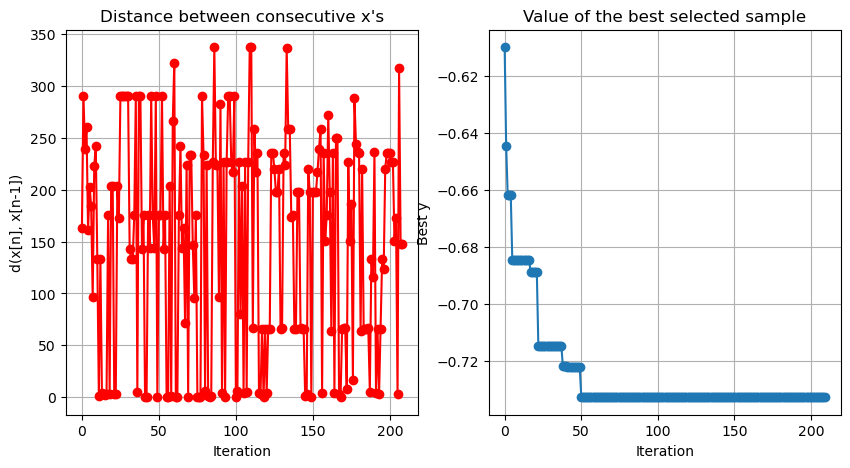

In [27]:
if Flag_BO_search:
    # plot the convergence
    bo.plot_convergence()

In [28]:
if Flag_BO_search:
    hypertable_sort = hypertable.sort_values(by = ['score_r2_HC'], ascending=False, ignore_index = True) # sort the list start from the best results

    display(hypertable_sort.head(3))

    # Save the sorted data to an Excel file
    output_file_name = model_path_bo+f"hypertable_sort_NN_full_RepeatedKFold_v3_bo_ens_{bo_ens_num}.xlsx"
    hypertable_sort.to_excel(output_file_name)

,score_r2_HC,score_r2_HC_best,score_loss_HC,score_r2_H,score_r2_C,score_loss_H,score_loss_C,NNF_num_nodes,NNH_num_nodes,NNC_num_nodes,NNF_num_layers,NNH_num_layers,NNC_num_layers,NNF_dropout,NNH_NNC_dropout,loss_class,learning_rate_H,learning_rate_C,batch_size_H,N_epochs_local
0,0.732852,0.732852,0.011444,0.702104,0.763600,0.011444,0.008302,32.0,256.0,128.0,0.0,3.0,5.0,0.409930,0.214725,0.0,0.0001,0.000100,16.0,3.0
1,0.732664,0.732664,0.011590,0.704880,0.760449,0.011590,0.008439,32.0,256.0,64.0,0.0,6.0,7.0,0.500000,0.225830,0.0,0.0001,0.002264,32.0,2.0
2,0.732336,0.732664,0.010973,0.705842,0.758829,0.010973,0.008735,32.0,256.0,64.0,0.0,5.0,7.0,0.380483,0.100000,0.0,0.0001,0.000100,32.0,2.0


### plotting the BO process

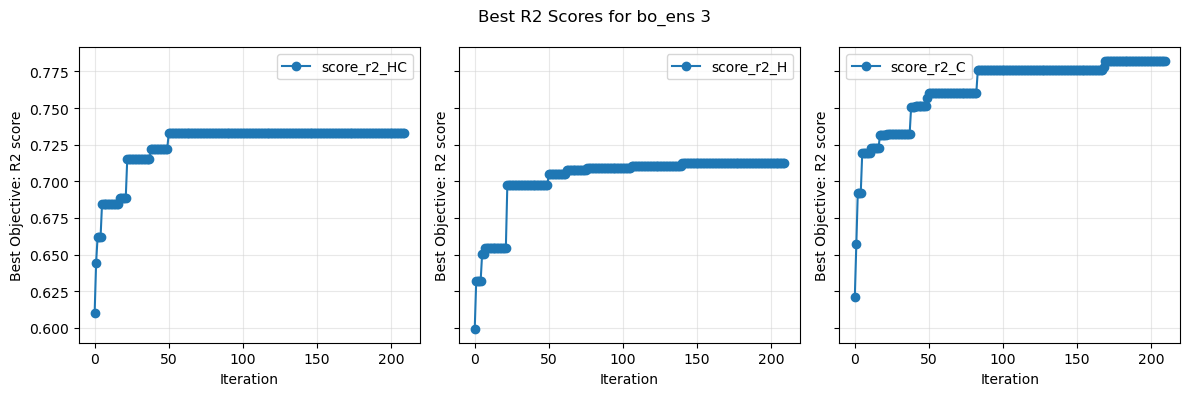

In [29]:
if Flag_BO_search:
    # Define a function to plot the best R2 score for a given column name
    def plot_best_r2_score(ax, col_name):
        data = hypertable[col_name].values
        best_scores = np.maximum.accumulate(data)
        ax.plot(best_scores, label=col_name, linestyle='-', marker='o')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Best Objective: R2 score')
        ax.grid(alpha=0.5, color='lightgrey')
        ax.legend()

    # Create a figure with three subplots
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

    # Call the function for each column and subplot
    col_names = ['score_r2_HC', 'score_r2_H', 'score_r2_C']
    for ax, col_name in zip(axs, col_names):
        plot_best_r2_score(ax, col_name)

    # Add a title to the figure
    fig.suptitle(f'Best R2 Scores for bo_ens {bo_ens_num}')
    fig.tight_layout()
    plt.savefig(model_path_bo+f'BO_score_r2_bo_ens_{bo_ens_num}.png', format='png', dpi=200)
    plt.show()


In [30]:
# you shall not pass

### model training: best in BO ranking

In [31]:
if Flag_Training_BO_best: 
    start_time = time.time()

    # loading the best BO hyperparameters
    hypertable_sort = pd.read_excel(model_path_bo + f"hypertable_sort_NN_full_RepeatedKFold_v3_bo_ens_{bo_ens_num}.xlsx")
    display(hypertable_sort.head(1))

    # inputs for `RepeatedKFold`
    k_folds = 6
    n_CVrepeats = 2

    # inputs for MinMaxScaler normalisation
    # scaler_compo, scaler_C_specific, scaler_output

    NNF_num_nodes, NNF_num_layers = int(hypertable_sort.loc[0, 'NNF_num_nodes']), int(hypertable_sort.loc[0, 'NNF_num_layers'])
    NNH_num_nodes, NNH_num_layers = int(hypertable_sort.loc[0, 'NNH_num_nodes']), int(hypertable_sort.loc[0, 'NNH_num_layers'])
    NNC_num_nodes, NNC_num_layers = int(hypertable_sort.loc[0, 'NNC_num_nodes']), int(hypertable_sort.loc[0, 'NNC_num_layers'])
    
    # inputs for model architecture
    mc_state     = True   # use MC dropout by `True` and otherwise `False`
    act          = 'relu' # activation function `leaky_relu`/`relu`

    NNF_dropout, NNH_dropout, NNC_dropout  = hypertable_sort.loc[0, 'NNF_dropout'], hypertable_sort.loc[0, 'NNH_NNC_dropout'], hypertable_sort.loc[0, 'NNH_NNC_dropout']

    loss_class    = int(hypertable_sort.loc[0, 'loss_class'])
    if loss_class == 0: 
        loss_func = tf.keras.metrics.mean_squared_error
    elif loss_class == 1: 
        loss_func = tf.keras.metrics.mean_absolute_error
    else:
        raise ValueError(f"Invalid loss function '{loss_class}' ")
        
    learning_rate_H, learning_rate_C = hypertable_sort.loc[0, 'learning_rate_H'], hypertable_sort.loc[0, 'learning_rate_C']

    batch_size_H    = int(hypertable_sort.loc[0, 'batch_size_H'])         # batch size used for H datasets and then calcuate for C dataset
    N_epochs_local  = int(hypertable_sort.loc[0, 'N_epochs_local'])        # local epochs
    N_epochs_global = int(5000/N_epochs_local)  # global epochs

    # whether to save the model and model architecture
    model_save_flag = True

    # evaluate model
    (train_loss_H, train_loss_C,
    val_loss_H,    val_loss_C,
    score_loss_H,  score_loss_C,
    score_r2_H,    score_r2_C)  = evaluate_NN_full_model(X1_train_norm_KFold, X1_test_norm_KFold, Y1_train_norm_KFold, Y1_test_norm_KFold, H1_train_norm_KFold, H1_test_norm_KFold, 
                                                        X2_train_norm_KFold, X2_test_norm_KFold, Z2_train_norm_KFold, Z2_test_norm_KFold, C2_train_norm_KFold, C2_test_norm_KFold, 
                                                        k_folds, n_CVrepeats, 
                                                        NNF_num_nodes, NNF_num_layers,
                                                        NNH_num_nodes, NNH_num_layers,
                                                        NNC_num_nodes, NNC_num_layers,
                                                        mc_state, act, 
                                                        NNF_dropout, NNH_dropout, NNC_dropout,
                                                        loss_func, learning_rate_H, learning_rate_C,
                                                        batch_size_H, N_epochs_global, N_epochs_local,
                                                        model_save_flag)

    elapsed_time = time.time() - start_time
    print("Time taken: ", int(elapsed_time), "seconds")

,Unnamed: 0,score_r2_HC,score_r2_HC_best,score_loss_HC,score_r2_H,score_r2_C,score_loss_H,score_loss_C,NNF_num_nodes,NNH_num_nodes,...,NNF_num_layers,NNH_num_layers,NNC_num_layers,NNF_dropout,NNH_NNC_dropout,loss_class,learning_rate_H,learning_rate_C,batch_size_H,N_epochs_local
0,0,0.732852,0.732852,0.011444,0.702104,0.7636,0.011444,0.008302,32,256,...,0,3,5,0.40993,0.214725,0,0.0001,0.0001,16,3


2023-04-02 18:33:14.223873: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 18:33:14.224004: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 18:33:14.224075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 18:33:14.224092: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 18:33:14.224135: W tensorflow/compiler/xla/

Time taken:  1830 seconds


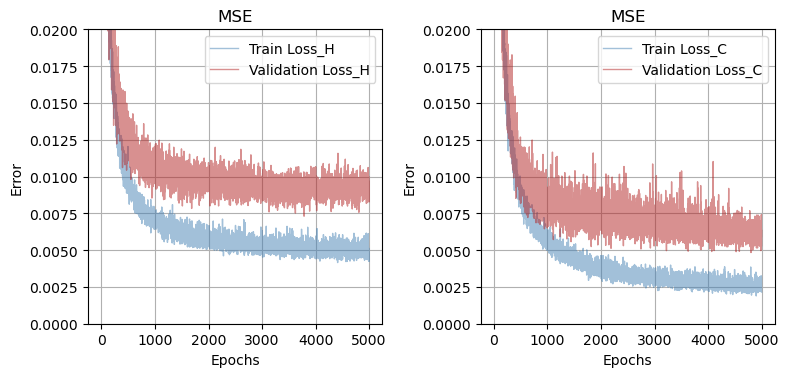

In [32]:
if Flag_Training_BO_best: 
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    for i in range(k_folds * n_CVrepeats):
        # ax[0].plot(train_loss_H[i], linewidth=1, color='steelblue', alpha=0.5)
        # ax[0].plot(val_loss_H[i], linewidth=1, color='firebrick', alpha=0.5)
        # ax[1].plot(train_loss_C[i], linewidth=1, color='steelblue', alpha=0.5)
        # ax[1].plot(val_loss_C[i], linewidth=1, color='firebrick', alpha=0.5)

        if i == 3:
            ax[0].plot(train_loss_H[i], label=f"Train Loss_H", linewidth=1, color='steelblue', alpha=0.5)
            ax[0].plot(val_loss_H[i],   label=f"Validation Loss_H", linewidth=1, color='firebrick', alpha=0.5)
            ax[1].plot(train_loss_C[i], label=f"Train Loss_C", linewidth=1, color='steelblue', alpha=0.5)
            ax[1].plot(val_loss_C[i],   label=f"Validation Loss_C", linewidth=1, color='firebrick', alpha=0.5)

    for axi in ax.flat:
        axi.set_xlabel("Epochs")
        axi.set_ylabel("Error")
        axi.set_title('MSE')
        axi.legend()
        axi.grid()
        axi.set_box_aspect(1)
        axi.set_ylim(0, 0.02)

    fig.tight_layout()
    plt.savefig(model_path_bo+'NN_full_RepeatedKFold_loss.png', format='png', dpi=200)
    plt.show()

## Evaluate the training results
#### Show the model.h5 files in this directory

In [33]:
if Flag_Training_BO_best: 
    # list all files in the directory
    files = sorted([f for f in os.listdir(model_path_bo) if f.endswith('.h5')])

    # create a table with the headers "NNH_model" and "NNC_model"
    table = [["NNH_model", "NNC_model"]]

    # loop through all files and add the filenames to the appropriate list
    nnh_files = [f for f in files if f.startswith('NNH_model_RepeatedKFold')]
    nnc_files = [f for f in files if f.startswith('NNC_model_RepeatedKFold')]

    # sort NNH_model files and NNC_model files by their integer suffix
    nnh_files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
    nnc_files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))

    # add the filenames to the table
    for i in range(12):
        nnh_file = nnh_files[i] if i < len(nnh_files) else ""
        nnc_file = nnc_files[i] if i < len(nnc_files) else ""
        table.append([nnh_file, nnc_file])

    # display the table
    print(tabulate(table, headers="firstrow"))

NNH_model                      NNC_model
-----------------------------  -----------------------------
NNH_model_RepeatedKFold_1.h5   NNC_model_RepeatedKFold_1.h5
NNH_model_RepeatedKFold_2.h5   NNC_model_RepeatedKFold_2.h5
NNH_model_RepeatedKFold_3.h5   NNC_model_RepeatedKFold_3.h5
NNH_model_RepeatedKFold_4.h5   NNC_model_RepeatedKFold_4.h5
NNH_model_RepeatedKFold_5.h5   NNC_model_RepeatedKFold_5.h5
NNH_model_RepeatedKFold_6.h5   NNC_model_RepeatedKFold_6.h5
NNH_model_RepeatedKFold_7.h5   NNC_model_RepeatedKFold_7.h5
NNH_model_RepeatedKFold_8.h5   NNC_model_RepeatedKFold_8.h5
NNH_model_RepeatedKFold_9.h5   NNC_model_RepeatedKFold_9.h5
NNH_model_RepeatedKFold_10.h5  NNC_model_RepeatedKFold_10.h5
NNH_model_RepeatedKFold_11.h5  NNC_model_RepeatedKFold_11.h5
NNH_model_RepeatedKFold_12.h5  NNC_model_RepeatedKFold_12.h5


### Check the training quality


#### define `predict_bootstrap` for prediction 

In [34]:
def predict_bootstrap(model_path, model_name,
                      X1_list, Y1_list, 
                      k_folds, n_CVrepeats, mc_repeat,
                      scaler_compo, scaler_H_specific, scaler_output):
    
    H1_pred_X1_list    = []
    H1_pred_X1_mc_mean = []
    H1_pred_X1_mc_std  = []
    
    
    def predict_one_model(i):

        # loading saved models
        NNH_model_loaded_temp = keras.models.load_model(os.path.join(model_path, model_name.format(i+1)))
        
        # make prediction
        def predict_one_sample():
            return scaler_output.inverse_transform(
                NNH_model_loaded_temp.predict([scaler_compo.transform(X1_list[i]), 
                                                   scaler_H_specific.transform(Y1_list[i])], 
                                                   verbose = 0)
                                                  )
            
        H1_pred_X1_mc_stack_temp = tf.map_fn(lambda _: predict_one_sample(),
                                             tf.range(mc_repeat),
                                             dtype=tf.float32,
                                             parallel_iterations=mc_repeat)
        
        H1_pred_X1_mc_mean_temp = np.mean(H1_pred_X1_mc_stack_temp, axis = 0).reshape((-1,))
        H1_pred_X1_mc_std_temp  = np.std(H1_pred_X1_mc_stack_temp,  axis = 0).reshape((-1,))
        
        return H1_pred_X1_mc_stack_temp, H1_pred_X1_mc_mean_temp, H1_pred_X1_mc_std_temp
    
    results = Parallel(n_jobs=-1)(delayed(predict_one_model)(i) for i in range(k_folds * n_CVrepeats))
    
    # clear TensorFlow session
    tf.keras.backend.clear_session()

    for mc_stack, mean, std in results:
        H1_pred_X1_list.append(mc_stack)
        H1_pred_X1_mc_mean.append(mean)
        H1_pred_X1_mc_std.append(std)

    return H1_pred_X1_list, H1_pred_X1_mc_mean, H1_pred_X1_mc_std


#### compute true vs predictions (test data) for each RepeatedKFold 

In [35]:
if Flag_Training_BO_best: 
    mc_repeat = 50

    NNH_model_name = 'NNH_model_RepeatedKFold_{}.h5'
    NNC_model_name = 'NNC_model_RepeatedKFold_{}.h5'

    with concurrent.futures.ThreadPoolExecutor() as executor:
        future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name, 
                                                    X1_test_KFold, Y1_test_KFold, 
                                                    k_folds, n_CVrepeats, mc_repeat,
                                                    scaler_compo, scaler_H_specific, scaler_H_output)

        future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name, 
                                                    X2_test_KFold, Z2_test_KFold, 
                                                    k_folds, n_CVrepeats, mc_repeat,
                                                    scaler_compo, scaler_C_specific, scaler_C_output)

    H1_test_pred_X1_stack, H1_test_pred_X1_mean, H1_test_pred_X1_std = future1.result()
    C2_test_pred_X2_stack, C2_test_pred_X2_mean, C2_test_pred_X2_std = future2.result()


2023-04-02 19:03:50.225879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 19:03:50.225879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 19:03:50.226018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2023-04-02 19:03:52.121054: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 19:03:52.121210: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 19:03:52.121643: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 19:03:52.121667: W tensorflow/compiler/tf2tensorrt/utils/py_

2023-04-02 19:03:56.661428: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 19:03:56.661477: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 19:03:56.661513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 19:03:56.661807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f4bc29e3670>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7fa916644670>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f2fcf4535e0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f3250877670>: no matching AST found among candidates:

To silence thi

Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f0817878940>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f5971695940>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f0803209940>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f95ddbb18b0>: no matching AST found among candidates:

To silence thi

2023-04-02 19:04:02.260455: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 19:04:02.260517: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 19:04:02.260575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 19:04:02.261245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### define `plot_test_true_vs_pred` for true vs predictions (test data)  

In [36]:
def plot_test_true_vs_pred(k_folds, n_CVrepeats, test_KFold, test_pred_mean, test_pred_std, lims, label, color, model_path):

    fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(18, 7))
    
    for i in range(k_folds * n_CVrepeats):
        # ----- plot true vs prediction -----
        row_idx = i // 6
        col_idx = i % 6
        ax[row_idx, col_idx].set_xlim(lims)
        ax[row_idx, col_idx].set_ylim(lims)
        ax[row_idx, col_idx].plot(lims, lims, color='grey')
        ax[row_idx, col_idx].scatter(test_KFold[i], test_pred_mean[i], label=label, color=color, alpha=0.5)
        ax[row_idx, col_idx].errorbar(x=test_KFold[i], y=test_pred_mean[i], yerr=test_pred_std[i], fmt='none', 
                                      ecolor=color, capsize=3, alpha=0.5)
        r = r2_score(test_KFold[i], test_pred_mean[i])
        ax[row_idx, col_idx].text(.05, .7, 'r2={:.2f}'.format(r), transform=ax[row_idx, col_idx].transAxes, color=color)
        ax[row_idx, col_idx].set_xlabel('True values in training dataset')
        ax[row_idx, col_idx].set_ylabel('Predictions')
        ax[row_idx, col_idx].set_aspect('equal', 'box')
        ax[row_idx, col_idx].legend(loc=4, prop={'size': 8})
        ax[row_idx, col_idx].grid()

    # adjust spacing and show plot
    fig.tight_layout()
    axs_title = label + '_RepeatedKFold_True_Prediction_testdata'
    fig.suptitle(axs_title, fontsize=18)
    plt.savefig(model_path + axs_title + '.png', bbox_inches='tight')
    plt.show()


#### plot true vs predictions (test data) for each RepeatedKFold 

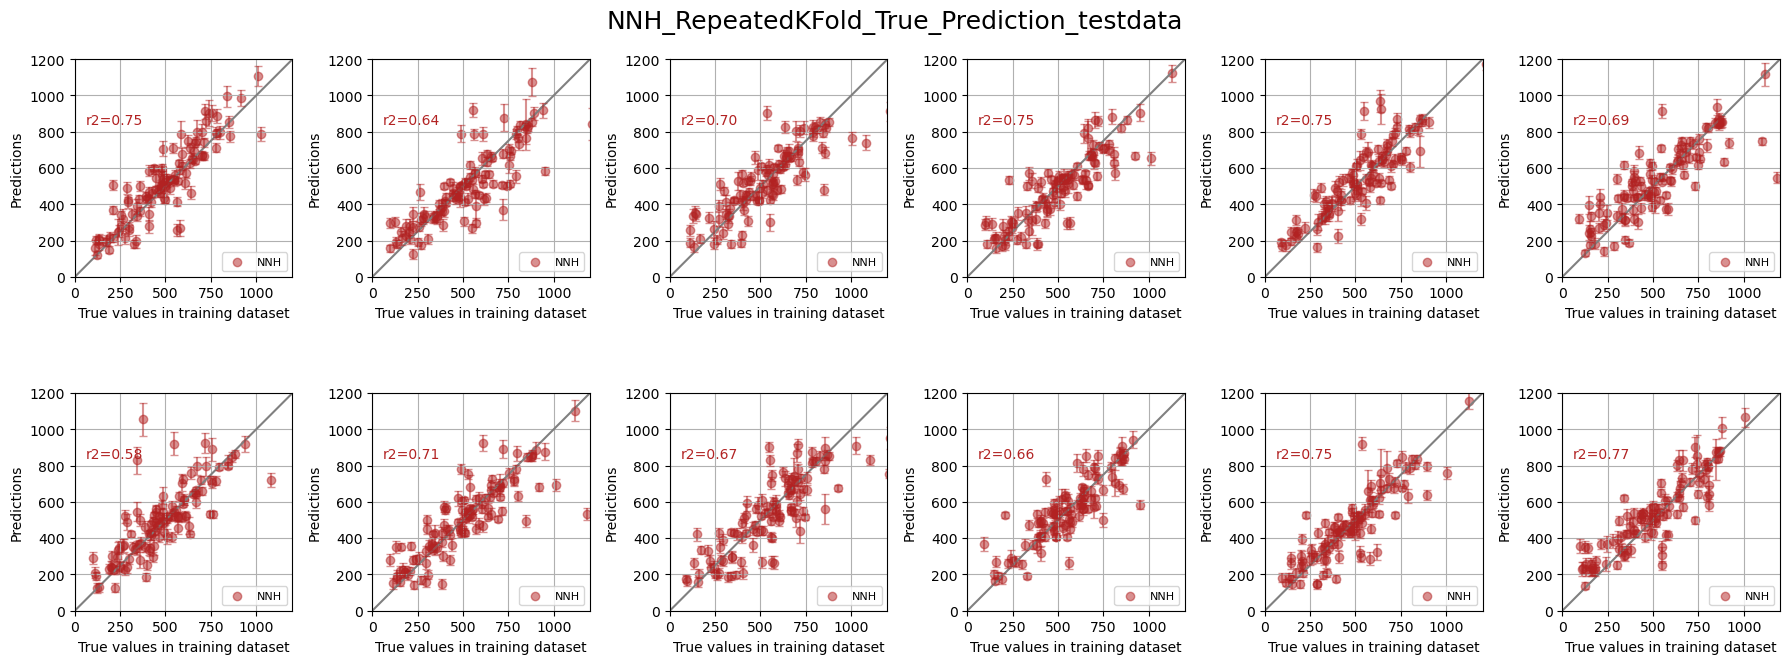

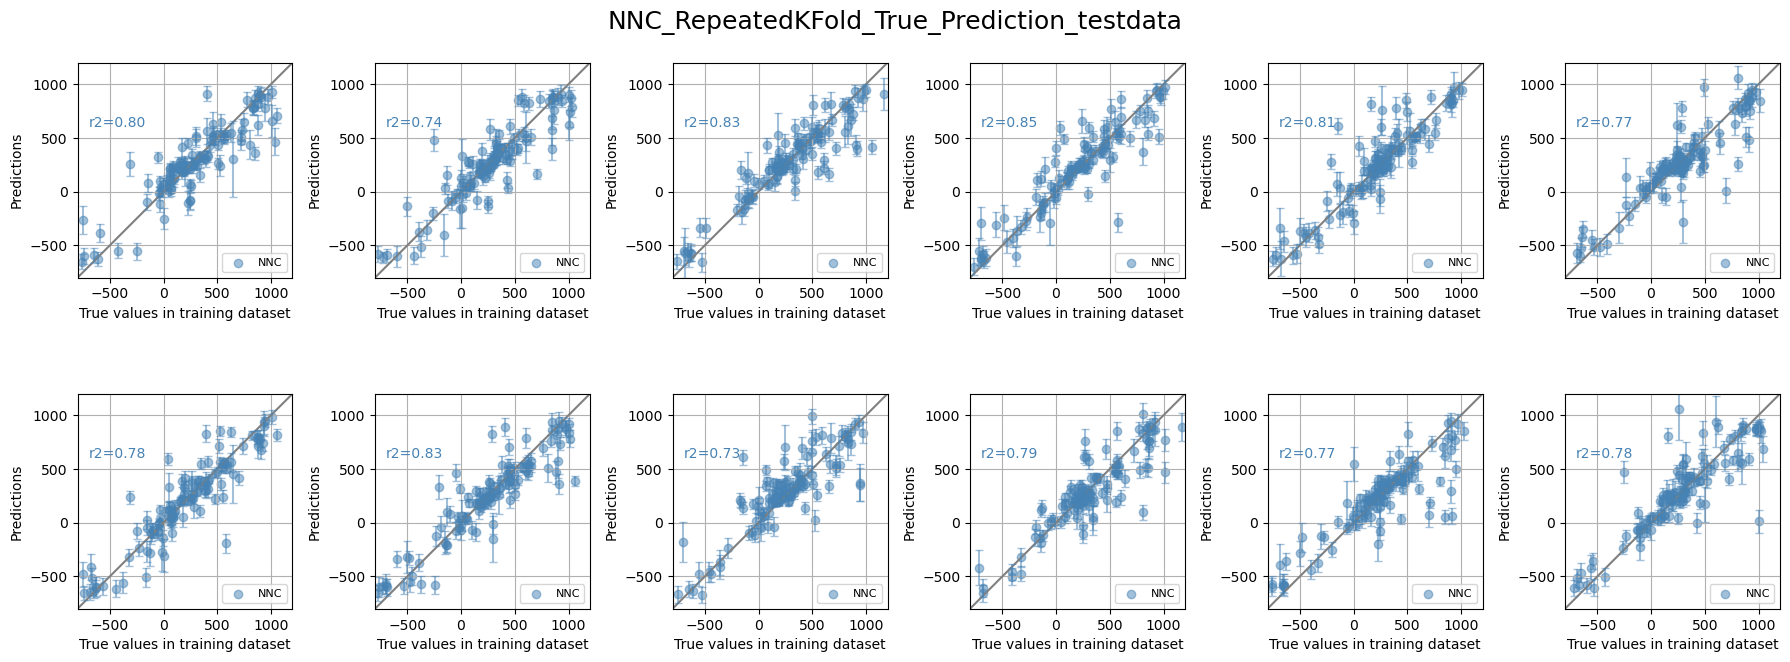

In [37]:
if Flag_Training_BO_best: 
    plot_test_true_vs_pred(k_folds, n_CVrepeats, H1_test_KFold, H1_test_pred_X1_mean, H1_test_pred_X1_std, 
                    [0, 1200], 'NNH', 'firebrick', model_path_bo)

    plot_test_true_vs_pred(k_folds, n_CVrepeats, C2_test_KFold, C2_test_pred_X2_mean, C2_test_pred_X2_std, 
                    [-800, 1200], 'NNC', 'steelblue', model_path_bo)


### make true vs predictions (based on the full dataset)

In [38]:
if Flag_Training_BO_best: 
    mc_repeat  = 50

    X1_list, Y1_list = [X1]*k_folds*n_CVrepeats, [Y1]*k_folds*n_CVrepeats
    X2_list, Z2_list = [X2]*k_folds*n_CVrepeats, [Z2]*k_folds*n_CVrepeats


    with concurrent.futures.ThreadPoolExecutor() as executor:
        future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name, 
                                                    X1_list, Y1_list, 
                                                    k_folds, n_CVrepeats, mc_repeat,
                                                    scaler_compo, scaler_H_specific, scaler_H_output)

        future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name, 
                                                    X2_list, Z2_list, 
                                                    k_folds, n_CVrepeats, mc_repeat,
                                                    scaler_compo, scaler_C_specific, scaler_C_output)

    H1_pred_X1_stack, H1_pred_X1_mean, H1_pred_X1_std = future1.result()
    C2_pred_X2_stack, C2_pred_X2_mean, C2_pred_X2_std = future2.result()


Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7fa916644280>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f9b485413a0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function predict_bootstrap.<locals>.predict_one_model.<locals>.<lambda> at 0x7f53f957a3a0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2023-04-02 19:04:12.487341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU

2023-04-02 19:04:13.983603: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 19:04:13.983726: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 19:04:13.983737: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-04-02 19:04:14.002126: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Co

2023-04-02 19:04:15.896315: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 19:04:15.896350: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 19:04:15.896381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 19:04:15.896637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

2023-04-02 19:04:16.141339: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-04-02 19:04:16.141399: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 19:04:16.141451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maws13): /proc/driver/nvidia/version does not exist
2023-04-02 19:04:16.141789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 

In [ ]:
if Flag_Training_BO_best: 
    H1_pred_X1_conc       = np.concatenate(H1_pred_X1_stack, axis=0)  # concatenate along the first axis
    H1_pred_X1_KFold_mean = np.mean(H1_pred_X1_conc, axis=0).reshape(-1)
    H1_pred_X1_KFold_std  = np.std(H1_pred_X1_conc, axis=0).reshape(-1)
    
    C2_pred_X2_conc       = np.concatenate(C2_pred_X2_stack, axis=0)  # concatenate along the first axis
    C2_pred_X2_KFold_mean = np.mean(C2_pred_X2_conc, axis=0).reshape(-1)
    C2_pred_X2_KFold_std  = np.std(C2_pred_X2_conc, axis=0).reshape(-1)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    lims = [[0, 1200], [-800, 1200]]

    for i, (data, label, color) in enumerate(zip([(H1, H1_pred_X1_KFold_mean, H1_pred_X1_KFold_std), 
                                                (C2, C2_pred_X2_KFold_mean, C2_pred_X2_KFold_std)],
                                                ['NNH_model', 'NNC_model'],
                                                ['steelblue', 'firebrick'])):
        ax[i].set(xlim=lims[i], ylim=lims[i], aspect='equal', box_aspect=1, xlabel='True values in training dataset',
                ylabel='Predictions', title=f'{label} - r2={r2_score(data[0], data[1]):.2f}')
        ax[i].plot(lims[i], lims[i], color='grey')
        ax[i].scatter(*data[:2], label=label, color=color, alpha=0.5)
        ax[i].errorbar(x=data[0], y=data[1], yerr=data[2], fmt='none', ecolor=color, capsize=3, alpha=0.3)
        ax[i].legend(loc=4, prop={'size': 8})
        ax[i].grid()

    fig.tight_layout()
    plt.savefig(model_path_bo + 'NN_full_RepeatedKFold_True_Prediction_fulldata.png', bbox_inches='tight')
    plt.show()


# Make predictions

In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from keras.models import Sequential
# from keras import layers
# from keras.layers import Dense, Concatenate, Dropout, BatchNormalization
# from keras.utils.vis_utils import plot_model

 
# from sklearn.metrics import r2_score
# from sklearn.preprocessing import MinMaxScaler
# import scipy as sp
# import seaborn as sns

# import numpy as np

# import pandas as pd
# import matplotlib.cm as cm
# import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker
# from tabulate import tabulate

# import time

# from multiprocessing import Pool
# from joblib import Parallel, delayed
# import concurrent.futures

# import pickle
# import os

# data_path  = './Dataset_Cleaned/'
# model_path = './Model_Saved/'


# # ----- BO-related -----
# notebook_fname = "NN_full_RepeatedKFold_v3_BO_1"
# num_str        = notebook_fname.split("_")[-1]

# try:
#     bo_ens_num = int(num_str)
#     print(f"bo_ens_num: {bo_ens_num}")
# except ValueError:
#     # if the string can't be converted to an integer, keep it as a string
#     bo_ens_num = int(123)
#     print(f"book master - bo_ens_num: {bo_ens_num}")
 

# model_path_bo = f'./{model_path}/{notebook_fname}/'

# if not os.path.exists(model_path_bo):
#     os.makedirs(model_path_bo)
#     print(f"Folder '{model_path_bo}' created.")
# else:
#     print(f"Folder '{model_path_bo}' already exists.")
# # ----- BO-related -----

# tf.keras.backend.clear_session()

#### load scalers

In [ ]:
# Load the scalers from the file
with open(data_path + 'scalers.pkl', 'rb') as f:
    (scaler_compo, 
     scaler_H_specific, 
     scaler_C_specific, 
     scaler_H_output, 
     scaler_C_output) = pickle.load(f)

#### coordinates for PVD alloy representation

In [ ]:
# load the wafer-coordinates
df_PVD_x_y = pd.read_excel(data_path + 'PVD_x_y.xlsx')
coord_x = df_PVD_x_y["x"].to_numpy(dtype=float)
coord_y = df_PVD_x_y["y"].to_numpy(dtype=float)
index_PVD_x_y = df_PVD_x_y.index.values+1
 

#### define `read_new_data` to load the inputs for making predictions

In [ ]:
def read_new_data(data_path, KW_name, vars_ele): 
       # ----- import the new dataset ----- 
       df_new_at = pd.read_excel(data_path + 'MultiTaskModel_' + KW_name + '_at_pct.xlsx')
       df_new_wt = pd.read_excel(data_path + 'MultiTaskModel_' + KW_name + '_wt_pct.xlsx')
       vars_ele  = vars_ele
       KW_name   = KW_name

       # ----- get the `df_compo_new` ------
       df_compo = pd.DataFrame(columns=['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn',
              'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf'])

       df_compo_new = pd.concat([df_compo, df_new_wt[vars_ele]], axis=0, ignore_index=True)
       df_compo_new = df_compo_new.fillna(0) # fill in the nan by zero

       compo_new    = np.asarray(df_compo_new.values)

       # ----- get the `df_H_specific_new` ----- 
       df_H_specific_new = df_new_at[['delta_a', 'Hmix', 'VEC', 'sigma_bulk_modulus']]

       H_specific_new = np.asarray(df_H_specific_new.values)


       # ----- get the `df_C_specifi_new` ----- 
       C_testing = np.array([25, 0.5, 7, 0.215]) # TestTemperature_C, ChlorideIonConcentration, pH, ScanRate_mVs
       C_specific_new = np.ones((len(df_compo_new. index), len(C_testing))) * C_testing # corrosion testing condition array
       # df_C_specific_new = pd.DataFrame(C_specific_new, columns=['TestTemperature_C', 'ChlorideIonConcentration', 'pH', 'ScanRate_mVs'])

       return compo_new, H_specific_new, C_specific_new


#### define `predict_bootstrap_NNH_NNC` for predictions from NNH and NNC

In [ ]:
def predict_bootstrap(model_path, model_name,
                      X1_list, Y1_list, 
                      k_folds, n_CVrepeats, mc_repeat,
                      scaler_compo, scaler_H_specific, scaler_output):
    
    H1_pred_X1_list    = []
    H1_pred_X1_mc_mean = []
    H1_pred_X1_mc_std  = []
    
    def predict_one_model(i):

        # loading saved models
        NNH_model_loaded_temp = keras.models.load_model(os.path.join(model_path, model_name.format(i+1)))
        
        # make prediction
        def predict_one_sample():
            return scaler_output.inverse_transform(
                NNH_model_loaded_temp.predict([scaler_compo.transform(X1_list[i]), 
                                                   scaler_H_specific.transform(Y1_list[i])], 
                                                   verbose = 0)
                                                  )
            
        H1_pred_X1_mc_stack_temp = tf.map_fn(lambda _: predict_one_sample(),
                                             tf.range(mc_repeat),
                                             dtype=tf.float32,
                                             parallel_iterations=mc_repeat)
        
        H1_pred_X1_mc_mean_temp = np.mean(H1_pred_X1_mc_stack_temp, axis = 0).reshape((-1,))
        H1_pred_X1_mc_std_temp  = np.std(H1_pred_X1_mc_stack_temp,  axis = 0).reshape((-1,))
        
        return H1_pred_X1_mc_stack_temp, H1_pred_X1_mc_mean_temp, H1_pred_X1_mc_std_temp
    
    results = Parallel(n_jobs=-1)(delayed(predict_one_model)(i) for i in range(k_folds * n_CVrepeats))
    
    # clear TensorFlow session
    tf.keras.backend.clear_session()

    for mc_stack, mean, std in results:
        H1_pred_X1_list.append(mc_stack)
        H1_pred_X1_mc_mean.append(mean)
        H1_pred_X1_mc_std.append(std)

    return H1_pred_X1_list, H1_pred_X1_mc_mean, H1_pred_X1_mc_std

In [ ]:

def predict_bootstrap_NNH_NNC(model_path_bo, NNH_model_name, NNC_model_name,
                               compo_new, H_specific_new, C_specific_new,
                               scaler_compo, scaler_H_specific, scaler_C_specific,
                               scaler_H_output, scaler_C_output,
                               k_folds, n_CVrepeats, mc_repeat):
    
    # Repeat new data to match number of CV repetitions
    compo_new_list = [compo_new]*k_folds*n_CVrepeats
    H_specific_new_list = [H_specific_new]*k_folds*n_CVrepeats
    C_specific_new_list = [C_specific_new]*k_folds*n_CVrepeats

    # Predict using bootstrap resampling in parallel
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name, 
                                                 compo_new_list, H_specific_new_list, 
                                                 k_folds, n_CVrepeats, mc_repeat,
                                                 scaler_compo, scaler_H_specific, scaler_H_output)
        future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name, 
                                                 compo_new_list, C_specific_new_list, 
                                                 k_folds, n_CVrepeats, mc_repeat,
                                                 scaler_compo, scaler_C_specific, scaler_C_output)

    # Retrieve results from parallel predictions
    H1_new_pred_stack, H1_new_pred_mean, H1_new_pred_std = future1.result()
    C2_new_pred_stack, C2_new_pred_mean, C2_new_pred_std = future2.result()
    
    return H1_new_pred_stack, H1_new_pred_mean, H1_new_pred_std, C2_new_pred_stack, C2_new_pred_mean, C2_new_pred_std

#### define `plot_prediction_uncertainty` for prediction and uncertainty for each fold in bootstrap on wafer-coordinates

In [ ]:
def plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y, 
                                pred_mean, pred_std, pred_label, unc_label, 
                                title, vmin1, vmax1, vmin2, vmax2, model_path):
    
    fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(18, 10), dpi=200)

    for i, (ax_pred, ax_unc) in enumerate(zip(axs[::2].flat, axs[1::2].flat)):
        # ----- subplot 1 prediction -----
        cax1 = ax_pred.scatter(coord_x, coord_y, c=pred_mean[i], s=400, marker='.', cmap='RdBu_r', vmin=vmin1, vmax=vmax1)
        ax_pred.set_xlabel('X')
        ax_pred.set_ylabel('Y')
        ax_pred.set_title(f'prediction {i+1}', fontsize=8)
        ax_pred.set_aspect('equal', 'box')
        for i_pvd, txt in enumerate(index_PVD_x_y):
            ax_pred.annotate(txt, (coord_x[i_pvd]-2, coord_y[i_pvd]-1), color="grey", alpha=1, fontsize=8)

        cbar1 = fig.colorbar(cax1, ax=ax_pred)
        cbar1.set_label(pred_label, size=8)
        cbar1.ax.tick_params(labelsize=8)

        # ----- subplot 2 prediction uncertainty -----
        cax2 = ax_unc.scatter(coord_x, coord_y, c=pred_std[i], s=400, marker='.', cmap='RdGy_r', vmin=vmin2, vmax=vmax2)
        ax_unc.set_xlabel('X')
        ax_unc.set_ylabel('Y')
        ax_unc.set_title(f'prediction uncertainty {i+1}', fontsize=8)
        ax_unc.set_aspect('equal', 'box')
        for i, txt in enumerate(index_PVD_x_y):
            ax_unc.annotate(txt, (coord_x[i]-3, coord_y[i]-1.5), color="grey", alpha=1, fontsize=8)

        cbar2 = fig.colorbar(cax2, ax=ax_unc)
        cbar2.set_label(unc_label, size=8)
        cbar2.ax.tick_params(labelsize=8)
        # -----------------------------------

    # adjust spacing and show plot
    plt.suptitle(title, fontsize=18)
    fig.tight_layout()
    plt.savefig(model_path + title + '.png', bbox_inches='tight')
    plt.show()


#### define `plot_prediction_uncertainty_AVG` for prediction and uncertainty for averaged bootstarp on wafer-coordinates

In [ ]:
def plot_prediction_uncertainty_AVG(coord_x, coord_y, index_PVD_x_y, H1_new_pred_stack, C2_new_pred_stack, 
                                    title, KW_name, model_path_bo):

    
    # ----- concatenate and compute mean and std -----
    H1_new_pred_KFold_mean = np.mean(np.concatenate(H1_new_pred_stack, axis=0), axis=0).reshape(-1)
    H1_new_pred_KFold_std  = np.std(np.concatenate(H1_new_pred_stack, axis=0), axis=0).reshape(-1)

    C2_new_pred_KFold_mean = np.mean(np.concatenate(C2_new_pred_stack, axis=0), axis=0).reshape(-1)
    C2_new_pred_KFold_std  = np.std(np.concatenate(C2_new_pred_stack, axis=0), axis=0).reshape(-1)

    # ----- plot true vs prediction for all the RepeatedKFold + MC_dropout -----
    # Set font size for all text in figure
    plt.rcParams.update({'font.size': 8})

    # Create figure with 2 subplots
    fig, ax = plt.subplots(2, 2, figsize=(6, 5), dpi=200)

    # Define plot details
    plot_details = [ (H1_new_pred_KFold_mean, H1_new_pred_KFold_std, 'Hardness', ''),    
                    (C2_new_pred_KFold_mean, C2_new_pred_KFold_std, 'Pitting potential', '(mV)')]

    # Loop through plot details and create subplots
    for i, (mean, std, name, unit) in enumerate(plot_details):
        row, col = i // 2, i % 2
        cmap1, cmap2 = plt.get_cmap('RdBu_r'), plt.get_cmap('RdGy_r')
        cax1 = ax[row, col].scatter(coord_x, coord_y, c=mean, s=400, marker='.', cmap=cmap1)
        cax2 = ax[row+1, col].scatter(coord_x, coord_y, c=std, s=400, marker='.', cmap=cmap2)
        ax[row, col].set_title(f'{name} ')
        ax[row+1, col].set_title(f'{name}  uncertainty')
        ax[row, col].set_aspect('equal')
        ax[row+1, col].set_aspect('equal')
        ax[row, col].set_xlabel('X')
        ax[row, col].set_ylabel('Y')
        ax[row+1, col].set_xlabel('X')
        ax[row+1, col].set_ylabel('Y')
        for i_pvd, txt in enumerate(index_PVD_x_y):
            ax[row, col].annotate(txt, (coord_x[i_pvd]-3, coord_y[i_pvd]-1.5), color="grey", alpha=1)
            ax[row+1, col].annotate(txt, (coord_x[i_pvd]-3, coord_y[i_pvd]-1.5), color="grey", alpha=1)
        cbar1, cbar2 = fig.colorbar(cax1, ax=ax[row, col]), fig.colorbar(cax2, ax=ax[row+1, col])
        cbar1.set_label(f'{name}  {unit}')
        cbar2.set_label(f'{name}  uncertainty {unit}')

    # adjust spacing and show plot
    plt.suptitle(title, fontsize=10)

    # Save and show figure
    fig.tight_layout()
    plt.savefig(model_path_bo + 'NN_full_RepeatedKFold_prediction_uncertainty_AVG_' + KW_name + '.png', bbox_inches='tight')
    plt.show()

#### make predictions for new alloys: KW131

In [ ]:
KW_name = 'KW131'
vars_ele = ['Fe', 'Cr', 'Ni', 'Mo', 'Ti']
k_folds     = 6
n_CVrepeats = 2
mc_repeat   = 100

NNH_model_name = 'NNH_model_RepeatedKFold_{}.h5'
NNC_model_name = 'NNC_model_RepeatedKFold_{}.h5'


compo_new, H_specific_new, C_specific_new = read_new_data(data_path, KW_name, vars_ele)

(H1_new_pred_stack, H1_new_pred_mean, H1_new_pred_std, 
 C2_new_pred_stack, C2_new_pred_mean, C2_new_pred_std) = predict_bootstrap_NNH_NNC(
                                                            model_path_bo, NNH_model_name, NNC_model_name,
                                                            compo_new, H_specific_new, C_specific_new,
                                                            scaler_compo, scaler_H_specific, scaler_C_specific, 
                                                            scaler_H_output, scaler_C_output,
                                                            k_folds, n_CVrepeats, mc_repeat)

# NNH predictions
pred_label, unc_label = 'Hardness', 'Hardness uncertainty'
title                 = 'NNH_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name
vmin1, vmax1          = 100, 300
vmin2, vmax2          = 25, 100
plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y, H1_new_pred_mean, H1_new_pred_std, 
                            pred_label, unc_label, title, vmin1, vmax1, vmin2, vmax2, model_path_bo)

# NNC predictions
pred_label, unc_label = 'Pitting potential (mV)', 'Pitting potential uncertainty (mV)'
title                 = 'NNC_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name
vmin1, vmax1          = 0,  900
vmin2, vmax2          = 50, 150
plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y, C2_new_pred_mean, C2_new_pred_std, 
                            pred_label, unc_label, title, vmin1, vmax1, vmin2, vmax2, model_path_bo)

# NNH_NNC_AVG predictions
title = 'NNH_NNC_RepeatedKFold_prediction_uncertainty_AVG_' + KW_name
plot_prediction_uncertainty_AVG(coord_x, coord_y, index_PVD_x_y, H1_new_pred_stack, C2_new_pred_stack, 
                                title, KW_name, model_path_bo)

#### make predictions for new alloys: KW99

In [ ]:
KW_name     = 'KW99'
vars_ele    = ['Fe', 'Cr', 'Ni', 'Co', 'V']
k_folds     = 6
n_CVrepeats = 2
mc_repeat   = 100

NNH_model_name = 'NNH_model_RepeatedKFold_{}.h5'
NNC_model_name = 'NNC_model_RepeatedKFold_{}.h5'


compo_new, H_specific_new, C_specific_new = read_new_data(data_path, KW_name, vars_ele)

(H1_new_pred_stack, H1_new_pred_mean, H1_new_pred_std, 
 C2_new_pred_stack, C2_new_pred_mean, C2_new_pred_std) = predict_bootstrap_NNH_NNC(
                                                            model_path_bo, NNH_model_name, NNC_model_name,
                                                            compo_new, H_specific_new, C_specific_new,
                                                            scaler_compo, scaler_H_specific, scaler_C_specific, 
                                                            scaler_H_output, scaler_C_output,
                                                            k_folds, n_CVrepeats, mc_repeat)

# NNH predictions
pred_label, unc_label = 'Hardness', 'Hardness uncertainty'
title                 = 'NNH_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name
vmin1, vmax1          = 100, 300
vmin2, vmax2          = 25, 100
plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y, H1_new_pred_mean, H1_new_pred_std, 
                            pred_label, unc_label, title, vmin1, vmax1, vmin2, vmax2, model_path_bo)

# NNC predictions
pred_label, unc_label = 'Pitting potential (mV)', 'Pitting potential uncertainty (mV)'
title                 = 'NNC_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name
vmin1, vmax1          = 0,  900
vmin2, vmax2          = 50, 150
plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y, C2_new_pred_mean, C2_new_pred_std, 
                            pred_label, unc_label, title, vmin1, vmax1, vmin2, vmax2, model_path_bo)

# NNH_NNC_AVG predictions
title = 'NNH_NNC_RepeatedKFold_prediction_uncertainty_AVG_' + KW_name
plot_prediction_uncertainty_AVG(coord_x, coord_y, index_PVD_x_y, H1_new_pred_stack, C2_new_pred_stack, 
                                title, KW_name, model_path_bo)

#### Load the inputs for making predictions: KW99

In [ ]:
# # ----- import the new dataset ----- 
# # df_new_at = pd.read_excel(data_path + 'MultiTaskModel_corrosion_PT1_KW131_at_pct.xlsx')
# # df_new_wt = pd.read_excel(data_path + 'MultiTaskModel_corrosion_PT1_KW131_wt_pct.xlsx')
# # vars_ele  = ['Fe', 'Cr', 'Ni', 'Mo', 'Ti']
# # KW_name   = 'KW131' 

# df_new_at = pd.read_excel(data_path + 'MultiTaskModel_KW99_at_pct.xlsx')
# df_new_wt = pd.read_excel(data_path + 'MultiTaskModel_KW99_wt_pct.xlsx')
# vars_ele  = ['Fe', 'Cr', 'Ni', 'Co', 'V']
# KW_name   = 'KW99' 



# # ----- get the `df_compo_new` ------
# df_compo = pd.DataFrame(columns=['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn',
#        'Cu', 'Al', 'V', 'Ta', 'Ti', 'Co', 'Mg', 'Y', 'Zr', 'Hf'])

# df_compo_new = pd.concat([df_compo, df_new_wt[vars_ele]], axis=0, ignore_index=True)
# df_compo_new = df_compo_new.fillna(0) # fill in the nan by zero

# compo_new    = np.asarray(df_compo_new.values)


# # ----- get the `df_H_specific_new` ----- 
# df_H_specific_new = df_new_at[['delta_a', 'Hmix', 'VEC', 'sigma_bulk_modulus']]

# H_specific_new = np.asarray(df_H_specific_new.values)


# # ----- get the `df_C_specifi_new` ----- 
# C_testing = np.array([25, 0.5, 7, 0.215]) # TestTemperature_C, ChlorideIonConcentration, pH, ScanRate_mVs
# C_specific_new = np.ones((len(df_compo_new. index), len(C_testing))) * C_testing # corrosion testing condition array

# df_C_specific_new = pd.DataFrame(C_specific_new, columns=['TestTemperature_C', 'ChlorideIonConcentration', 'pH', 'ScanRate_mVs'])

#### make predictions for new alloys: KW99

In [ ]:
# mc_repeat  = 100

# NNH_model_name = 'NNH_model_RepeatedKFold_{}.h5'
# NNC_model_name = 'NNC_model_RepeatedKFold_{}.h5'

# compo_new_list      = [compo_new]*k_folds*n_CVrepeats
# H_specific_new_list = [H_specific_new]*k_folds*n_CVrepeats
# C_specific_new_list = [C_specific_new]*k_folds*n_CVrepeats

# with concurrent.futures.ThreadPoolExecutor() as executor:
#     future1 = executor.submit(predict_bootstrap, model_path_bo, NNH_model_name, 
#                                                  compo_new_list, H_specific_new_list, 
#                                                  k_folds, n_CVrepeats, mc_repeat,
#                                                  scaler_compo, scaler_H_specific, scaler_H_output)

#     future2 = executor.submit(predict_bootstrap, model_path_bo, NNC_model_name, 
#                                                  compo_new_list, C_specific_new_list, 
#                                                  k_folds, n_CVrepeats, mc_repeat,
#                                                  scaler_compo, scaler_C_specific, scaler_C_output)

# H1_new_pred_stack, H1_new_pred_mean, H1_new_pred_std = future1.result()
# C2_new_pred_stack, C2_new_pred_mean, C2_new_pred_std = future2.result()


#### plotting for prediction and uncertainty on wafer-coordinates: KW99

In [ ]:
# pred_label, unc_label = 'Hardness prediction', 'Hardness prediction uncertainty'
# title                 = 'NNH_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name
# vmin1, vmax1          = 100, 300
# vmin2, vmax2          = 25, 100
# plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y, H1_new_pred_mean, H1_new_pred_std, 
#                             pred_label, unc_label, title, vmin1, vmax1, vmin2, vmax2, model_path_bo)

# pred_label, unc_label = 'Pitting potential prediction (mV)', 'Pitting potential prediction uncertainty (mV)'
# title                 = 'NNC_RepeatedKFold_prediction_uncertainty_eachFold_' + KW_name
# vmin1, vmax1          = 0,  900
# vmin2, vmax2          = 50, 150
# plot_prediction_uncertainty(coord_x, coord_y, index_PVD_x_y, C2_new_pred_mean, C2_new_pred_std, 
#                             pred_label, unc_label, title, vmin1, vmax1, vmin2, vmax2, model_path_bo)

#### make predictions for new alloys: averaged over bootstrap: KW99

In [ ]:
# # ----- concatenate and compute mean and std -----
# H1_new_pred_KFold_mean = np.mean(np.concatenate(H1_new_pred_stack, axis=0), axis=0).reshape(-1)
# H1_new_pred_KFold_std  = np.std(np.concatenate(H1_new_pred_stack, axis=0), axis=0).reshape(-1)

# C2_new_pred_KFold_mean = np.mean(np.concatenate(C2_new_pred_stack, axis=0), axis=0).reshape(-1)
# C2_new_pred_KFold_std  = np.std(np.concatenate(C2_new_pred_stack, axis=0), axis=0).reshape(-1)

# # ----- plot true vs prediction for all the RepeatedKFold + MC_dropout -----
# # Set font size for all text in figure
# plt.rcParams.update({'font.size': 8})

# # Create figure with 2 subplots
# fig, ax = plt.subplots(2, 2, figsize=(8, 7))

# # Define plot details
# plot_details = [ (H1_new_pred_KFold_mean, H1_new_pred_KFold_std, 'Hardness', 'VHN'),    
#                  (C2_new_pred_KFold_mean, C2_new_pred_KFold_std, 'Pitting potential', 'mV')]

# # Loop through plot details and create subplots
# for i, (mean, std, name, unit) in enumerate(plot_details):
#     row, col = i // 2, i % 2
#     cmap1, cmap2 = plt.get_cmap('RdBu_r'), plt.get_cmap('RdGy_r')
#     cax1 = ax[row, col].scatter(coord_x, coord_y, c=mean, s=400, marker='.', cmap=cmap1)
#     cax2 = ax[row+1, col].scatter(coord_x, coord_y, c=std, s=400, marker='.', cmap=cmap2)
#     ax[row, col].set_title(f'{name} prediction')
#     ax[row+1, col].set_title(f'{name} prediction uncertainty')
#     ax[row, col].set_aspect('equal')
#     ax[row+1, col].set_aspect('equal')
#     ax[row, col].set_xlabel('X')
#     ax[row, col].set_ylabel('Y')
#     ax[row+1, col].set_xlabel('X')
#     ax[row+1, col].set_ylabel('Y')
#     for i_pvd, txt in enumerate(index_PVD_x_y):
#         ax[row, col].annotate(txt, (coord_x[i_pvd]-2, coord_y[i_pvd]-1), color="grey", alpha=1)
#         ax[row+1, col].annotate(txt, (coord_x[i_pvd]-2, coord_y[i_pvd]-1), color="grey", alpha=1)
#     cbar1, cbar2 = fig.colorbar(cax1, ax=ax[row, col]), fig.colorbar(cax2, ax=ax[row+1, col])
#     cbar1.set_label(f'{name} prediction ({unit})')
#     cbar2.set_label(f'{name} prediction uncertainty ({unit})')

# # Save and show figure
# plt.savefig(model_path_bo + 'NN_full_RepeatedKFold_prediction_uncertainty_AVG_' + KW_name + '.png', bbox_inches='tight')
# plt.show()
